## <center> Topic Trend Detection of the Neural Information Processing Systems Conference </center>
## <center> Haitao Shang

In [3]:
import numpy as np
import pandas as pd
import string
import random
import re
import pprint
import math
from time import time

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jmpegna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jmpegna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<span style="color:blue">
    The below piece of code is just to avoid the scroll in the subsequent plots, because there are going to be multiple figures with a number of rows, each row with a couple of plots
</span>

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<span style="color:blue">
    We register the time, to see how long it takes to execute the entire notebook.
</span>

In [5]:
# Register the time when we start executing the notebook
tx = time()

#### Read the file

<span style="color:blue">
    We have cleaned up manually the file containing the papers. As a result, the file `cleanup_papers_abstract.csv` has been created and it is going to be used in the entire notebook.
    The cleanup process has consisted of removing the lines that did not have values in any of the essential columns: `id`, `year`, `title` and `paper_text`. Also, for all the values in `paper_text`, we have removed the information what came before the abstract, as normally it is personal information related to the author.<br>
    Below we can see that we have kept an important number of papers to analysis (over 7000), enough to produce the analysis.
</span>

In [6]:
# Read the csv file from disk
papers_df = pd.read_csv("cleanup_papers_abstract.csv")

# Print the dimensions of the dataframe and the first rows to see that everything is OK
print("Number of papers to analyze: " + str(papers_df.shape[0]))
papers_df.head(n=10)

Number of papers to analyze: 7180


id  year                                              title event_type  \
0   1  1987  Self-Organization of Associative Database and ...        NaN   
1   2  1987  The Capacity of the Kanerva Associative Memory...        NaN   
2   3  1987  Supervised Learning of Probability Distributio...        NaN   
3   4  1987              Constrained Differential Optimization        NaN   
4   5  1987  Towards an Organizing Principle for a Layered ...        NaN   
5   6  1987  A Neural-Network Solution to the Concentrator ...        NaN   
6   7  1987  Experimental Demonstrations of Optical Neural ...        NaN   
7   9  1987                      Learning on a General Network        NaN   
8  10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
9  11  1987  Microelectronic Implementations of Connectioni...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  2-the-capacity-of-the-kanerva-associative-memo...  Abstract Missing   
2  3-supervised-learning-of-probability-distribut...  Abstract Missing   
3        4-constrained-differential-optimization.pdf  Abstract Missing   
4  5-towards-an-organizing-principle-for-a-layere...  Abstract Missing   
5  6-a-neural-network-solution-to-the-concentrato...  Abstract Missing   
6  7-experimental-demonstrations-of-optical-neura...  Abstract Missing   
7                9-learning-on-a-general-network.pdf  Abstract Missing   
8  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
9  11-microelectronic-implementations-of-connecti...  Abstract Missing   

                                          paper_text  
0  ABSTRACT\nAn efficient method of self-organizi...  
1  ABSTRACT\nThe capacity of an associative memor...  
2  Abstract:\nWe propose that the back propagatio...  
3  Abstract\nMany optimization models of neural n...  
4  Abstract\nAn information-theoretic optimizatio...  
5  ABSTRACT\nNetworks of simple analog processors...  
6  ABSTRACT\nWe describe two expriments in optica...  
7  Abstract\nThis paper generalizes the backpropa...  
8  ABSTRACT\nA single cell theory for the develop...  
9  Abstract\nIn this paper we discuss why special...

#### Remove meaningless columns and generate lists for years, titles and paper texts

<span style="color:blue">
    We are dropping the columns `id`, `event_type`, `pdf_name` and `abstract` from our analysis.<br>
    For the rest of the notebook we are keeping 3 columns: `year`, `title` and `paper_text`.<br>
    In order to process the information easily, we are keeping each column in a diferent dataset.
</span>

In [7]:
# Keep only the year, title and paper text from the original dataframe
papers_filtered = papers_df.drop(['id', 'event_type', 'pdf_name', 'abstract'], axis=1)

# Convert title and paper_text to lower case
title_lc = [title.lower() for title in papers_filtered.title]
paper_text_lc = [paper_text.lower() for paper_text in papers_filtered.paper_text]
years = [year for year in papers_filtered.year]

#### Functions to plot dataframes

<span style="color:blue">
    Below there are functions that we are using throughout the notebook to plot the results. We are explaining them separately.
</span>

In [8]:
# This is just a helper function to get a plot which is centered on the origin in Matplotlib

set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        

<span style="color:blue">
    The 2 functions below are meant to plot a dataframe whose first column is the `year` and the remaining columns are scores of terms (words, n-grams, concepts, topics, etc).<br><br>
    The purpose of the plots is to see by eye the evolution of each term throughout the time, and identify more easily the presence of a trend.<br><br>
    The intent of plotting all the terms together is to see if there are outstanding terms.<br><br>
    The intent of plotting each term indivivually is to have a zoom of the behaviour of the term throughout the time. In the individual plot, also, it is plotted the regression line, as a way to identify the trend.<br>
    Finally, in the individual plot, there is another regression line, only taking into consideration the last 5 years, to see if there is a more localized trend.
</span>

In [9]:
# Function to display in 1 plot all the terms in the dataframe, to be analyzed.
# Years are displayed in the X axis and each term is displayed as a new line in the plot

def plot_term_df_all_together(term_df, term_name = "Words"):
    # Set the figure size
    plt.figure(figsize=(20,12))
    
    # The column year is our X axis
    # Each of the rest of the columns is a term. We are plotting each term in a different line
    year_list = term_df['Year']
    term_list = list(term_df.columns.values)[1:]
    
    for term in term_list:
        term_distr = term_df[term]
        plt.plot(year_list, term_distr, label=term)
    
    plt.legend(loc='upper right', frameon=True, framealpha=0.6, 
               scatterpoints=1, bbox_to_anchor=(1.30, 1), title=term_name, fontsize=10)
    
    plt.xlabel('Year', fontsize=15)
    plt.ylabel('TOP ' + str(len(term_list)) + ' ' + term_name, fontsize=15)
    plt.show()

# Function to plot individually all the terms included in the dataframe    
# Years are displayed in the X axis and each term is displayed as a new plot
# Each plot also displays a regression line that fits the data for all the years
# Finally, the plot displays a second regression line, just for the last 5 years, by default
# to be able to indentified more recent trends

def plot_term_df_individually(term_df, term_name = "Word", trend_years=5):
    
    # List with the slopes per term
    term_slope_list = []
    
    # Number of terms to plot, from column 1 to the end
    term_list = list((term_df.columns.values)[1:])
    
    # Calculations to display the same range for all the plots
    # to help the comparison among plots
    max_values = term_df.iloc[:,1:]
    max_value = max(max_values.max(axis=0))
    
    # Number of rows to plot, considering that we are going to plot 2 columns per row
    figure_rows = math.ceil(len(term_list) / 2)
    
    # Create the subplots and set the size of the image
    figure, ax_arr = plt.subplots(figure_rows, 2)
    figure.set_size_inches(20, figure_rows * 6)
    
    # Get a flat vector of plots, to help the access
    ax_vector = np.ravel(ax_arr)
    
    # Vector containing the years
    term_df = term_df.fillna(value=0.0)
    year_list = list(term_df['Year'])
    
    # Iterate through the list of topics
    for i, term in enumerate(term_list):
        # Access to the data of the term
        term_distr = term_df[term]
    
        # Access to the corresponding subplot, set the range in the y-axis
        current_ax = ax_vector[i]
        current_ax.set_ylim([0, max_value])
        current_ax.set_xlabel("Year", fontsize=10)
        current_ax.set_title(term_name + "=" + str(term), fontsize=15)
        
        # Plot the topic data
        current_ax.plot(year_list, term_distr, label="Score for \""+ term + "\"")
        
        # Number of years for a trend
        trend = trend_years
        
        # Calculating the 2 regression lines
        z = np.polyfit(year_list, term_distr, 1)
        z_trend = np.polyfit(year_list[len(year_list) - trend - 1:], term_distr[len(year_list) - trend - 1:], 1)
        
        p = np.poly1d(z)
        p_trend = np.poly1d(z_trend)
        
        x1 = year_list[0]
        x2 = year_list[len(year_list)-1]
                
        x3 = year_list[len(year_list)- trend - 1]
        x4 = year_list[len(year_list)-1]
        
        y1 = p(x1)
        y2 = p(x2)
        y3 = p_trend(x3)
        y4 = p_trend(x4)
        
        # Calculating the slope
        slope = (y2 - y1)/(x2-x1)
        slope_trend = (y4 - y3)/(x4-x3)
        
        term_slope_list.append((term, np.mean(term_distr), slope, slope_trend))
             
            
        # Plot the 2 regression lines    
        current_ax.plot(year_list,p(year_list),
                        "r--", label="Slope for " + str(len(year_list)) + " years = " + str(slope))
        
        current_ax.plot(year_list[len(year_list) - trend - 1:],p_trend(year_list[len(year_list)- trend - 1:]),
                        "-.", label="Slope for the last " + str(trend) + " years = " + str(slope_trend), color="black")
        
        current_ax.legend(loc='upper right',frameon=True,framealpha=0.6, scatterpoints=1,
                          bbox_to_anchor=(0.75, 1))
                  
    plt.show()
    
    term_slope_df = pd.DataFrame(term_slope_list, columns=['Term', "Mean score", 'Total slope', "Last years slope"])
    return term_slope_df

#### Functions to pre-process the corpora

<span style="color:blue">
    Below there are functions to process the corpora:<br><br>
    -`num_and_short_word_preprocessor` removes numbers, 1-letter and 2-letter words.<br>
    -`create_stop_words` uses the stop words from nltk and also adds a list of more words derived from an iterative analysis of the most frequent words in the corpora.<br>
    -`custom_tokenizer` breaks down the corpora into words and removes the plural of words.<br>
    -`preprocess_corpora` is just a pipeline of the above functions.
</span>

In [10]:
# Function to remove numbers and small words (1 or 2 letters) from a document
def num_and_short_word_preprocessor(tokens):
    # Regular expression for numbers
    no_numbers = re.sub('(\d)+', '', tokens.lower())
    
    # Regular expression for 1-letter and 2-letter words
    no_short_words = re.sub(r'\b\w{1,2}\b', '', no_numbers)
    
    return no_short_words

# Function to return a list of stop words to consider
def create_stop_words():
    # We create a stop word list
    stops = set(stopwords.words("english"))

    # We define individual numbers and letters as stop words
    all_letters_numbers = string.digits + string.ascii_letters

    stops = stops.union(['abstract', 'using', 'based', 'via', 'data', 'log', 'upper', 'lower',
                        'mit', 'press', 'shown', 'figure', 'set', 'information', 'processing',
                        'step', 'basis', 'error', 'rate', 'ha', 'two', 'one', 'also', 'given',
                        'example', 'number', 'used', 'wa', 'weight', 'point', 'case', 'result',
                        'show', 'value', 'input', 'output', 'different', 'first', 'use'])  # add some stopwords
    
    stops = stops.union(list(all_letters_numbers))
    
    return stops

# Function to convert plurals into singulars
def custom_tokenizer(doc):
    word_tokenizer = RegexpTokenizer(r'\w+')
    tokens = word_tokenizer.tokenize(doc)

    wnl = WordNetLemmatizer()
    singular_tokens = [wnl.lemmatize(i) for i in tokens]
 
    return singular_tokens

def preprocess_corpora(corpora):

    no_num_short_word_corpora = [num_and_short_word_preprocessor(sentence) for sentence in corpora]
    
    stemmed_corpora = [custom_tokenizer(doc) for doc in no_num_short_word_corpora]

    processed_corpora = []
    for doc in stemmed_corpora:
        processed_corpora.append([word for word in doc if not word in stop_words])
    
    return processed_corpora

# Word concepts - BOW

<span style="color:blue">
    The first approach we are using is Bag of Words (BOW). To do that, we use the class `CountVectorizer` and we do an analysis of 1-gram and 2-grams terms, separately, to see the most frequent terms in each of this two categories.<br><br>
    Following are the key aspects of the BOW analysis:<br><br>
    -`Frequency` of terms is analyzed per year.<br>
    -`Normalization` is done by dividing the number of occurrences of a term into the ratio (#words/#documents) in the year. That way we normalize taking into account the total number of words in a year and the number of documents in a year.<br>
    -`Localized frequency`: the algorithm selects the TOP most frequent terms in the whole corpora and also the TOP most frequent terms each year to be able to perform a more comprehensive analaysis by the plots. This way, if a term is very frequent a given year, but it is not anylonger, this term is going to be considered in the whole analysis.
    
</span>

In [11]:
def create_bow(corpora, stop, ngram = 1): 
    vectorizer = CountVectorizer(stop_words = stop, ngram_range = (ngram, ngram), 
                                 preprocessor = num_and_short_word_preprocessor, tokenizer=custom_tokenizer)
    
    vec = vectorizer.fit(corpora)
    bow = vec.transform(corpora)
    
    #print(bow)

    return vec, bow

def get_bow_per_year(years, corpora, stop = [], ngram = 1, num_freq_words=5, num_freq_words_year=5, 
                     normalice=False, debug = False):
    
    # Run the BOW for the corpora
    vec, bow = create_bow(corpora, stop, ngram)
    
    # List to store the frequency of words per year
    frequent_words_per_year = []
    
    # Create a list with the unique set of years
    year_list = list(sorted(set(years)))

    # Iterate for each year
    for year in year_list:
        # List of the indexes that contains the row numbers of a given year
        idx = [i for i, x in enumerate(years) if x == year]

        # Sub-matrix with the ocurrences for a given year
        documents_in_a_year = bow[idx,]

        # Total number of words for a given year, to be used to normalize
        total_words_year = documents_in_a_year.sum()
        num_documents = len(idx)

        # Vector that contains the sum for each word
        sum_word_matrix = documents_in_a_year.sum(axis=0)
        
        # If we want to normalize, the sum of terms in a year is divided by ratio of the number of terms
        # in all the documents of the year per number of documents
        if normalice:
            sum_word_matrix = sum_word_matrix / (total_words_year / num_documents)
            
        sum_word_list = np.array(sum_word_matrix)[0].tolist()
        
        # Append the sum of frequencies of a given year
        frequent_words_per_year.append(sum_word_list)
        
        if debug:
            print("Year = " + str(year))
            print("Documents in the year = " + str(len(idx)))
            print("Total words in the year = " + str(total_words_year))
            #print(words_freq[0:num_freq_words])
            print("\n")
    
    # Create a dataframe with the years as rows and the sorted vocabulary as columns
    vocabulary = vec.vocabulary_.items()
    sorted_vocabulary = sorted(vocabulary, key = lambda x: x[0], reverse=False)
    sorted_words = [key for key, value in sorted_vocabulary]
    bow_per_year_df = pd.DataFrame(frequent_words_per_year, columns=sorted_words)
   
    # Fill the set with the most frequent terms per year
    freq_words_set = set()
    # Iterate for each year to get the X most frequent words per year
    for index, row in bow_per_year_df.iterrows():  
        sorted_freq_words_year = row.sort_values(ascending=False)
        most_frequest_word_year_list = sorted_freq_words_year.index[0:num_freq_words_year]
        freq_words_set.update(most_frequest_word_year_list)

    # Calculate the sum of each word (sum per column), and order the Series in descending order
    freq_words = bow_per_year_df.sum(axis=0)
    sorted_freq_words = freq_words.sort_values(ascending=False)
    
    # Keep the most frequent and store them as a set
    most_freq_words_corpora_list = sorted_freq_words.index[0:num_freq_words]
    most_freq_words_corpora_set = set(most_freq_words_corpora_list)
    
    most_freq_words_corpora_set.update(freq_words_set)
    
    bow_per_year_df = bow_per_year_df[list(most_freq_words_corpora_set)]
    bow_per_year_df.insert(loc=0, column='Year', value=year_list)
    
    return bow_per_year_df

In [12]:
stop_words = create_stop_words()

## BOW with 1-gram analysis

<span style="color:blue">
    In this section we are analyzing 1-gram terms (words), keeping the 25 most frequent words during the 31 years, plus adding the most frequent word (if it is not included yet) per year.<br>
    We are normalizing following the criteria explain at the beginning of the section.
</span>

In [143]:
t0 = time()

word_df = get_bow_per_year(years, paper_text_lc, stop = stop_words, num_freq_words=25, num_freq_words_year=1, 
                           ngram = 1, debug = False, normalice = True)

print("done in %0.3fs." % (time() - t0))

done in 292.599s.


<span style="color:blue">
    Below we can see the score (normalized occurrences) of the most frequent words.
</span>

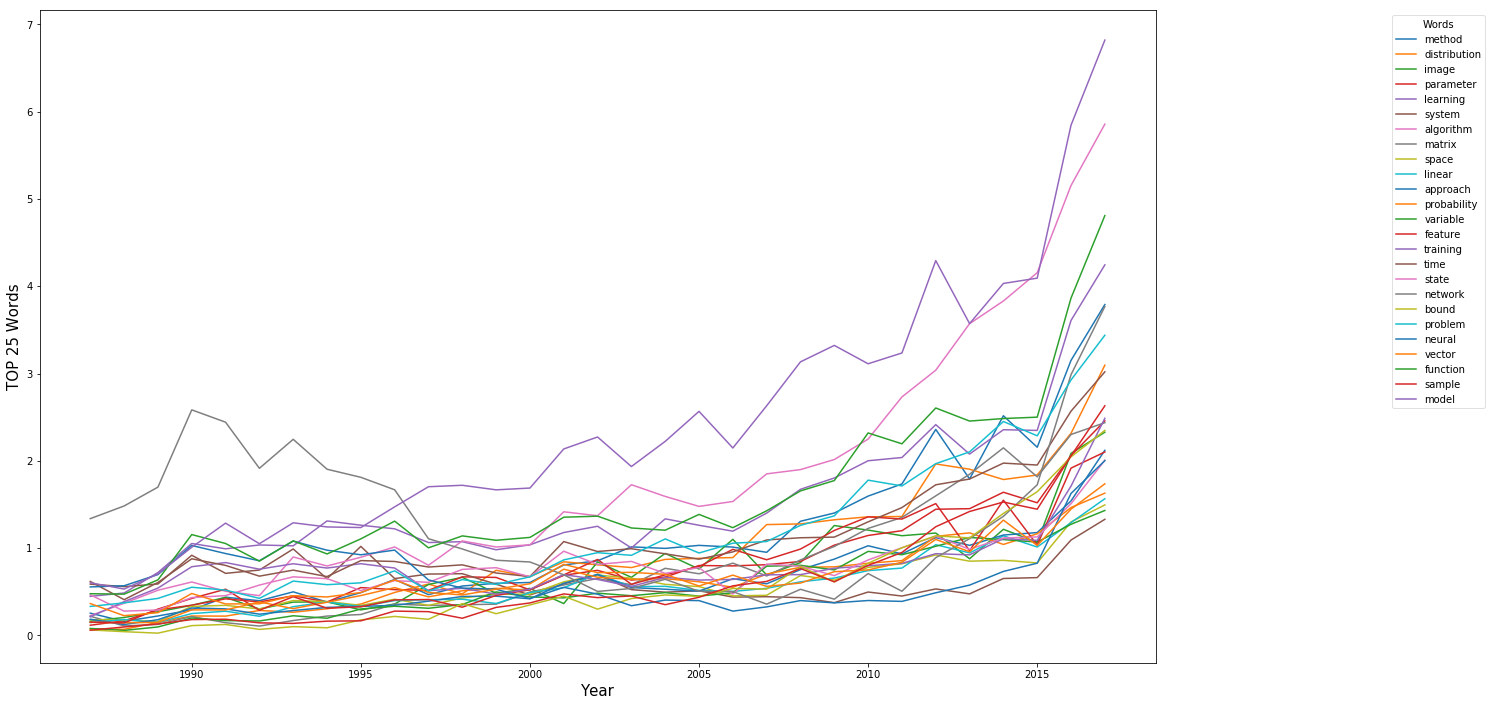

In [144]:
plot_term_df_all_together(word_df, term_name = "Words")

<span style="color:blue">
    Below we can see the individual plot for each word.
</span>

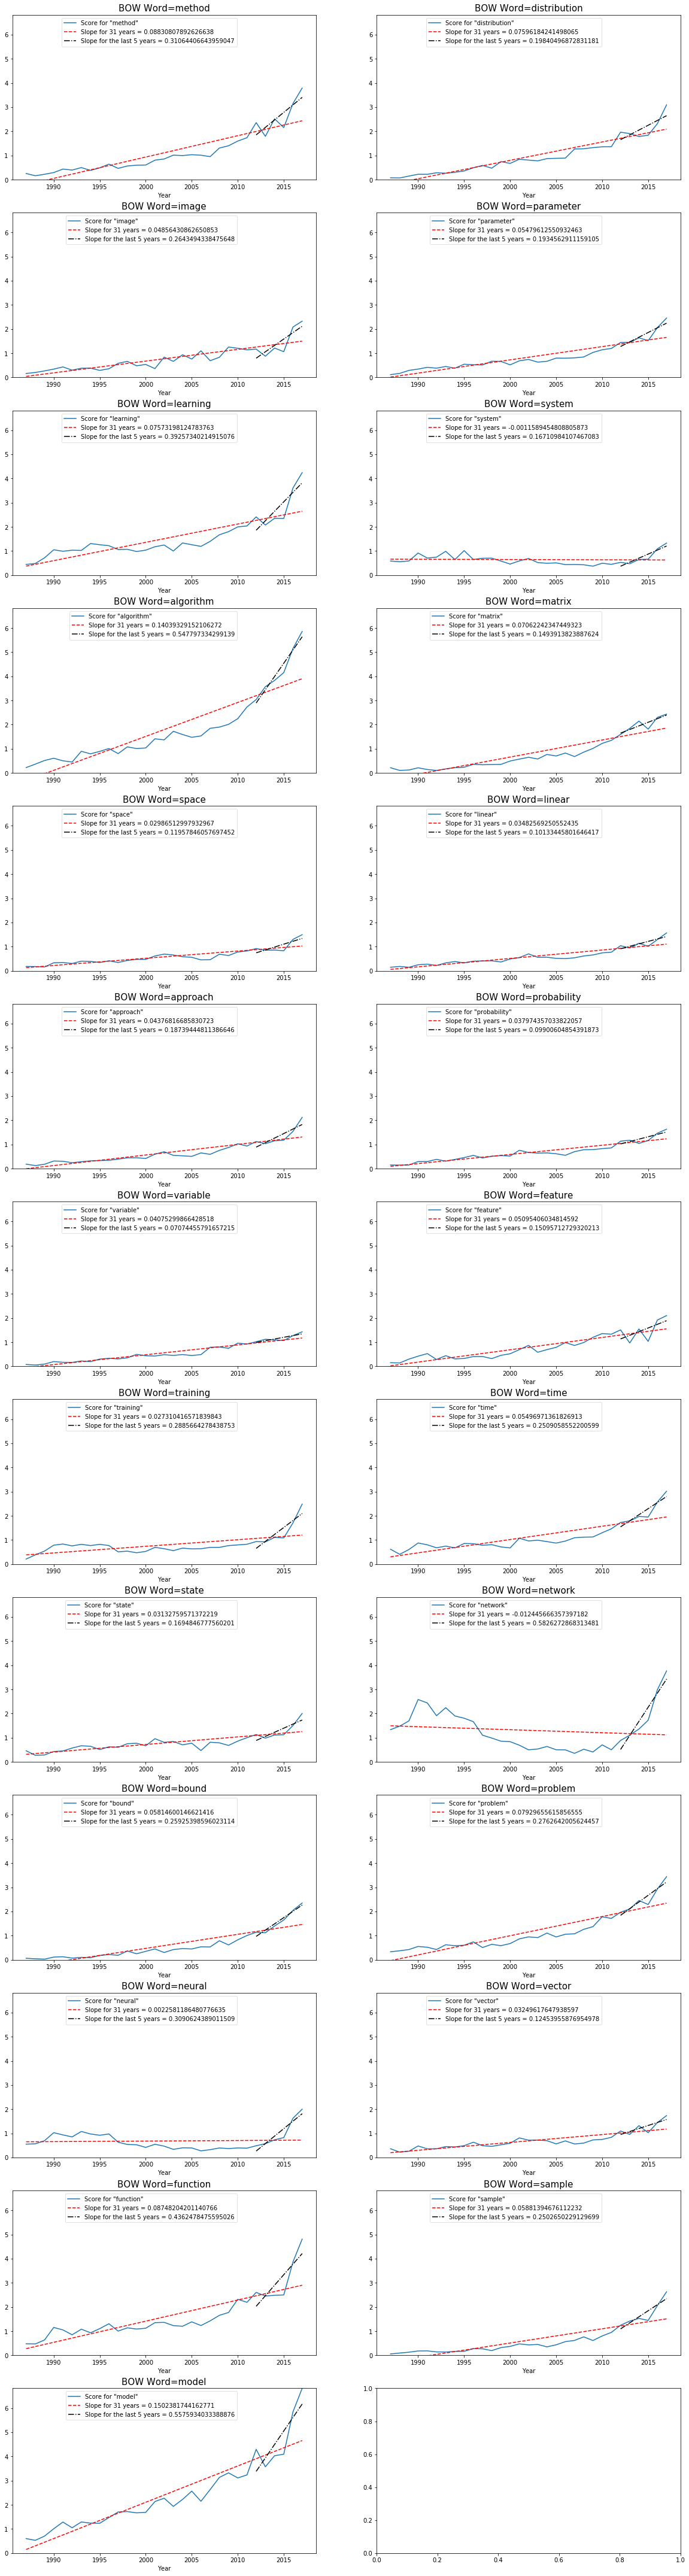

In [145]:
term_slope_df = plot_term_df_individually(word_df, term_name = "BOW Word")

<span style="color:blue">
    In the below 3 tables we can see the following facts, after preprocessing and normalizing:<br>
    -The most frequent words are `model`, `algorithm`, `function`, `learning` and `network`.<br>
    -The words with better trend in 31 years are `algorithm`, `method`, `function`, `problem` and `distribution`.<br>
    -The words that show better trend in the last 5 years are `network`, `model`, `algorithm`, `function` and `learning`.
</span>

In [148]:
term_slope_df.sort_values(by='Mean score', ascending = False).iloc[:,[0,1]]

Term  Mean score
24         model    2.405162
6      algorithm    1.795905
22      function    1.589604
4       learning    1.512202
17       network    1.310015
19       problem    1.153206
15          time    1.129032
0         method    1.111704
1   distribution    0.950591
3      parameter    0.836158
7         matrix    0.801144
14      training    0.793768
13       feature    0.789156
16         state    0.786377
2          image    0.772027
21        vector    0.690526
20        neural    0.686654
11   probability    0.662220
10      approach    0.650354
5         system    0.646807
23        sample    0.627995
18         bound    0.587569
9         linear    0.581314
8          space    0.578150
12      variable    0.562698

In [149]:
term_slope_df.sort_values(by='Total slope', ascending = False).iloc[:,[0,2]]

Term  Total slope
24         model     0.150238
6      algorithm     0.140393
0         method     0.088308
22      function     0.087482
19       problem     0.079297
1   distribution     0.075962
4       learning     0.075732
7         matrix     0.070622
23        sample     0.058814
18         bound     0.058146
15          time     0.054970
3      parameter     0.054796
13       feature     0.050954
2          image     0.048564
10      approach     0.043768
12      variable     0.040753
11   probability     0.037974
9         linear     0.034826
21        vector     0.032496
16         state     0.031328
8          space     0.029865
14      training     0.027310
20        neural     0.002258
5         system    -0.001159
17       network    -0.012446

In [150]:
term_slope_df.sort_values(by='Last years slope', ascending = False).iloc[:,[0,3]]

Term  Last years slope
17       network          0.582627
24         model          0.557593
6      algorithm          0.547797
22      function          0.436248
4       learning          0.392573
0         method          0.310644
20        neural          0.309062
14      training          0.288566
19       problem          0.276264
2          image          0.264349
18         bound          0.259254
15          time          0.250906
23        sample          0.250265
1   distribution          0.198405
3      parameter          0.193456
10      approach          0.187394
16         state          0.169485
5         system          0.167110
13       feature          0.150957
7         matrix          0.149391
21        vector          0.124540
8          space          0.119578
9         linear          0.101334
11   probability          0.099006
12      variable          0.070745

## BOW with 2-gram analysis

<span style="color:blue">
    In this section we are analyzing 2-gram terms, keeping the 25 most frequent terms during the 31 years, plus adding the most frequent terms (if not included yet) per year.<br>
    We are normalizing following the criteria explain at the beginning of the section.
</span>

In [151]:
t0 = time()

word_df = get_bow_per_year(years, paper_text_lc, stop = stop_words, num_freq_words=25, num_freq_words_year=1, 
                           ngram = 2, debug = False, normalice = True)

print("done in %0.3fs." % (time() - t0))

done in 575.570s.


<span style="color:blue">
    Below we can see the score (normalized occurrences) of the most frequent 2-grams.
</span>

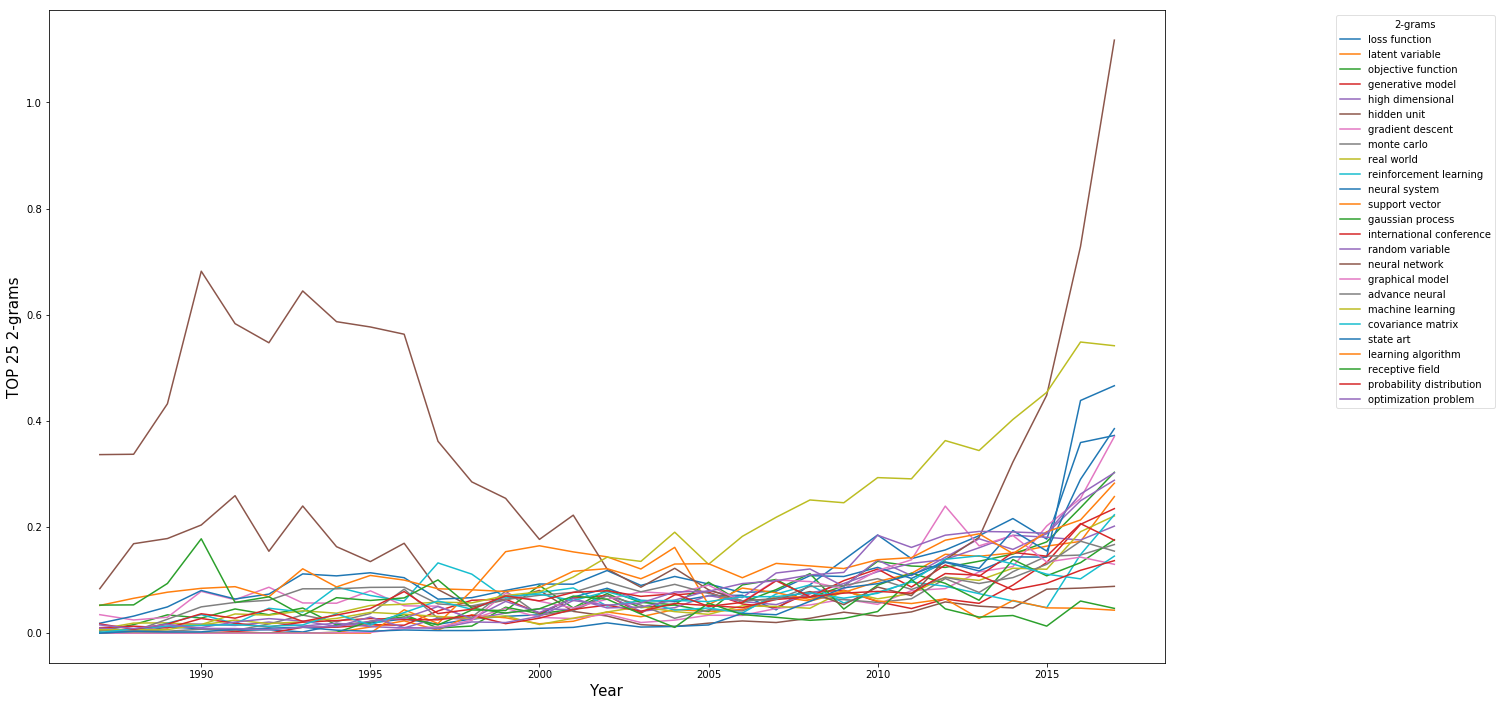

In [152]:
plot_term_df_all_together(word_df, term_name = "2-grams")

<span style="color:blue">
    Below we can see the individual plot for each 2-gram.
</span>

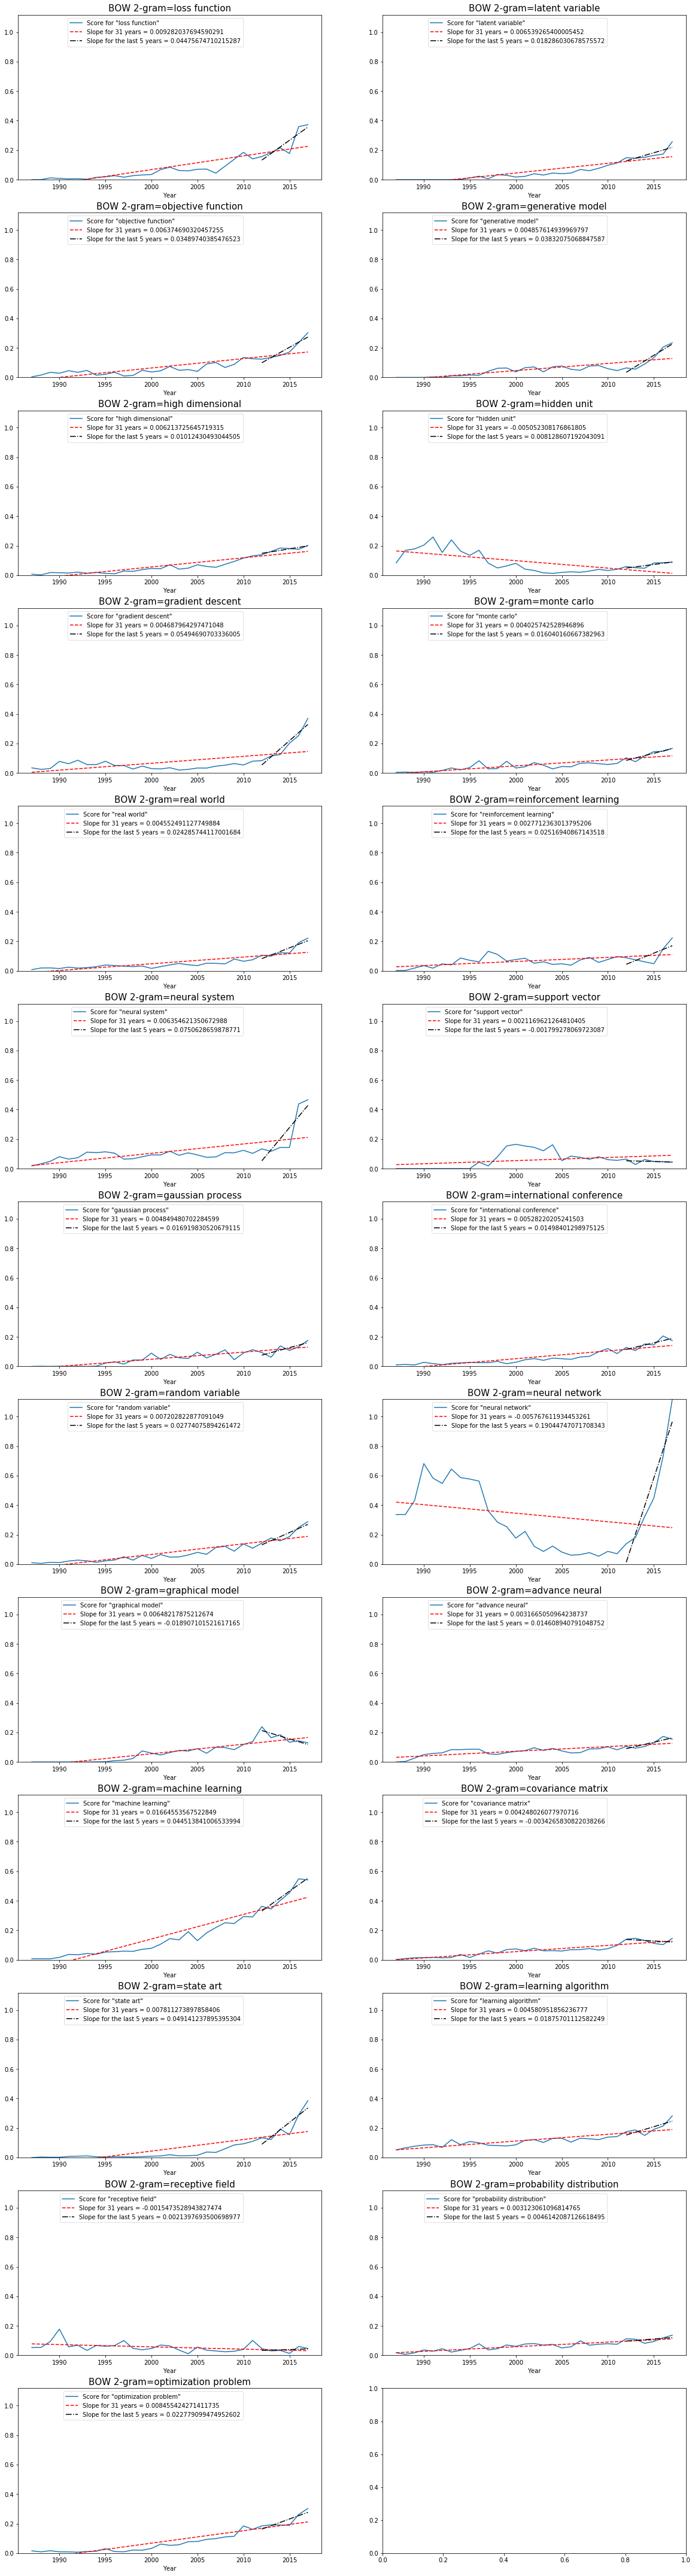

In [153]:
term_slope_df = plot_term_df_individually(word_df, term_name = "BOW 2-gram")

<span style="color:blue">
    In the below 3 tables we can observe the following facts:<br>
    -The most frequent 2-grams are `neural network`, `machine learning`, `learning algorithm`, `neural system` and `loss function`.<br>
    -The 2-grams with better trend in 31 years are `machine learning`, `loss function`, `optimization problem`, `state art` and `random variable`.<br>
    -The words that show better trend in the last 5 years are `neural network`, `neural system`, `gradient descent`, `state art` and `loss function`.<br>
    -We can observe the hype that `neural network` had, then it declined but it has gone up again very strongly in the last 5 years.
</span>

In [154]:
term_slope_df.sort_values(by='Mean score', ascending = False).iloc[:,[0,1]]

Term  Mean score
15            neural network    0.333902
18          machine learning    0.174026
21        learning algorithm    0.120894
10             neural system    0.116112
5                hidden unit    0.088557
0              loss function    0.086577
24      optimization problem    0.084534
14           random variable    0.080387
17            advance neural    0.078894
2         objective function    0.076835
6           gradient descent    0.075495
9     reinforcement learning    0.068712
16           graphical model    0.068599
4           high dimensional    0.068299
23  probability distribution    0.064589
19         covariance matrix    0.063452
13  international conference    0.062596
20                 state art    0.059553
11            support vector    0.058265
1            latent variable    0.058070
12          gaussian process    0.057950
8                 real world    0.056697
7                monte carlo    0.056312
3           generative model    0.055978
22           receptive field    0.054480

In [155]:
term_slope_df.sort_values(by='Total slope', ascending = False).iloc[:,[0,2]]

Term  Total slope
18          machine learning     0.016646
0              loss function     0.009282
24      optimization problem     0.008455
20                 state art     0.007811
14           random variable     0.007203
1            latent variable     0.006539
16           graphical model     0.006482
2         objective function     0.006375
10             neural system     0.006355
4           high dimensional     0.006214
13  international conference     0.005282
3           generative model     0.004858
12          gaussian process     0.004849
6           gradient descent     0.004688
21        learning algorithm     0.004581
8                 real world     0.004552
19         covariance matrix     0.004248
7                monte carlo     0.004026
17            advance neural     0.003167
23  probability distribution     0.003123
9     reinforcement learning     0.002771
11            support vector     0.002117
22           receptive field    -0.001547
5                hidden unit    -0.005052
15            neural network    -0.005768

In [156]:
term_slope_df.sort_values(by='Last years slope', ascending = False).iloc[:,[0,3]]

Term  Last years slope
15            neural network          0.190447
10             neural system          0.075063
6           gradient descent          0.054947
20                 state art          0.049141
0              loss function          0.044757
18          machine learning          0.044514
3           generative model          0.038321
2         objective function          0.034897
14           random variable          0.027741
9     reinforcement learning          0.025169
8                 real world          0.024286
24      optimization problem          0.022779
21        learning algorithm          0.018757
1            latent variable          0.018286
12          gaussian process          0.016920
7                monte carlo          0.016040
13  international conference          0.014984
17            advance neural          0.014609
4           high dimensional          0.010124
5                hidden unit          0.008129
23  probability distribution          0.004614
22           receptive field          0.002140
11            support vector         -0.001799
19         covariance matrix         -0.003427
16           graphical model         -0.018907

# Word concepts - TF-IDF

<span style="color:blue">
    The second approach we are using is Term frequency–inverse document frequency (TF-IDF). To do that, we use the class `TfidfVectorizer` and we do an analysis of 1-gram and 2-grams terms, separately, to see the most frequent terms in each of this two categories.<br><br>
    Following are the key aspects of the TF-IDF analysis:<br><br>
    -`Frequency` of terms is analyzed considering the documents for each year separatelly.<br>
    -`Normalization` is done by dividing the TF-IDF score into the ratio (#words/#documents) in the year. That way we normalize taking into account the total number of words in a year and the number of documents in a year.<br>
    -`Localized frequency`: the algorithm selects the TOP most frequent terms in the whole corpora and also the TOP most frequent terms each year to be able to perform a more comprehensive analaysis by the plots. This way, if a term is very frequent a given year, but it is not anylonger, this term is going to be considered in the whole analysis.
    
</span>

In [180]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

def create_tf_idf(corpora, stop, ngram = 1): 
    vectorizer = TfidfVectorizer(stop_words = stop, ngram_range = (ngram, ngram), 
                                 preprocessor = num_and_short_word_preprocessor, tokenizer=custom_tokenizer)
    
    vec = vectorizer.fit(corpora)
    bow = vec.transform(corpora)

    return vec, bow

def get_tf_idf_per_year(years, corpora, stop = [], ngram = 1, num_freq_words=5, num_freq_words_year=5, 
                     normalice=False, debug = False):
    
    # Create a list with the unique years
    year_list = list(sorted(set(years)))
        
    tf_idf_per_year_df = pd.DataFrame()
    
    # Iterate for each year
    for year in year_list:
        # List of the indexes that contains the row numbers of a given year
        idx = [i for i, x in enumerate(years) if x == year]
        
        # Sub-vector with the documents for a given year
        documents_in_a_year = [corpora[index] for index in idx]
        
        # Total number of words for a given year, to be used to normalize
        total_words_year = recursive_len(documents_in_a_year)
        num_documents = len(idx)
        
        vec, bow = create_tf_idf(documents_in_a_year, stop, ngram)
        
        # Vector that contains the sum for each word
        sum_word_matrix = bow.sum(axis=0)

        # If we want to normalize, the sum of terms in a year is divided by ratio of the number of terms
        # in all the documents of the year per number of documents
        if normalice:
            sum_word_matrix = sum_word_matrix / (total_words_year / num_documents)

        sum_word_list = np.array(sum_word_matrix)[0].tolist()
        
        # Create a dataframe with the years as rows and the sorted vocabulary as columns

        vocabulary = vec.vocabulary_.items()
        sorted_vocabulary = sorted(vocabulary, key = lambda x: x[0], reverse=False)
        sorted_words = [key for key, value in sorted_vocabulary]

        bow_per_year_df = pd.DataFrame(columns=sorted_words)
        bow_per_year_df.loc[0] = sum_word_list

        tf_idf_per_year_df = tf_idf_per_year_df.append(bow_per_year_df, sort=True)
        
        if debug:
            print("Year = " + str(year))
            print("Documents in the year = " + str(len(documents_in_a_year)))
            print("\n")
        
    
    tf_idf_per_year_df = tf_idf_per_year_df.fillna(value=0.0)

    freq_words_set = set()
    # Iterate for each year to get the X most frequent words per year
    for index, row in tf_idf_per_year_df.iterrows():  
        #print(row)
        sorted_freq_words_year = row.sort_values(ascending=False)
        most_frequest_word_year_list = sorted_freq_words_year.index[0:num_freq_words_year]
        #print(most_frequest_word_year_list)
        freq_words_set.update(most_frequest_word_year_list)

    # Calculate the sum of each word (sum per colum), and order the Series in descending order
    freq_words = tf_idf_per_year_df.sum(axis=0)
    sorted_freq_words = freq_words.sort_values(ascending=False)
    
    # Keep the most frequent and store them as a set
    most_freq_words_corpora_list = sorted_freq_words.index[0:num_freq_words]
    most_freq_words_corpora_set = set(most_freq_words_corpora_list)
    
    most_freq_words_corpora_set.update(freq_words_set)
    
    tf_idf_per_year_df = tf_idf_per_year_df[list(most_freq_words_corpora_set)]
    tf_idf_per_year_df.insert(loc=0, column='Year', value=year_list)
    
    return tf_idf_per_year_df
    

## TF-IDF with 1-gram analysis

<span style="color:blue">
    In this section we are analyzing 1-gram terms (words), keeping the 25 most frequent words during the 31 years, plus adding the most frequent word (if it is not included yet) per year.<br>
    We are normalizing following the criteria explain at the beginning of the section.
</span>

In [129]:
t0 = time()

tf_idf_word_df = get_tf_idf_per_year(years, paper_text_lc, stop = stop_words, num_freq_words=25, 
                                     ngram = 1, debug = False, normalice=True)

print("done in %0.3fs." % (time() - t0))

done in 483.477s.


<span style="color:blue">
    Below we can see the score (normalized occurrences) of the most frequent words.
</span>

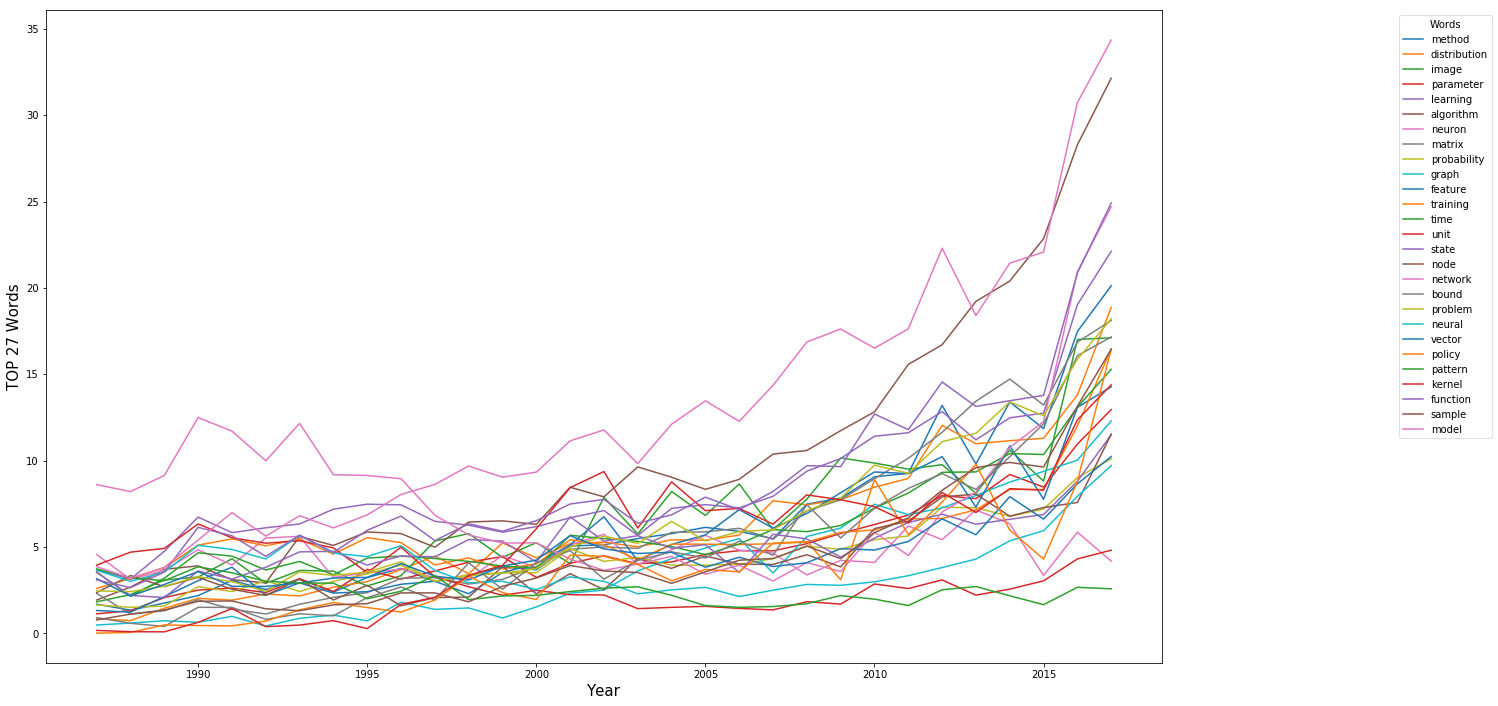

In [130]:
plot_term_df_all_together(tf_idf_word_df, term_name = "Words")

<span style="color:blue">
    Below we can see the individual plot for each word.
</span>

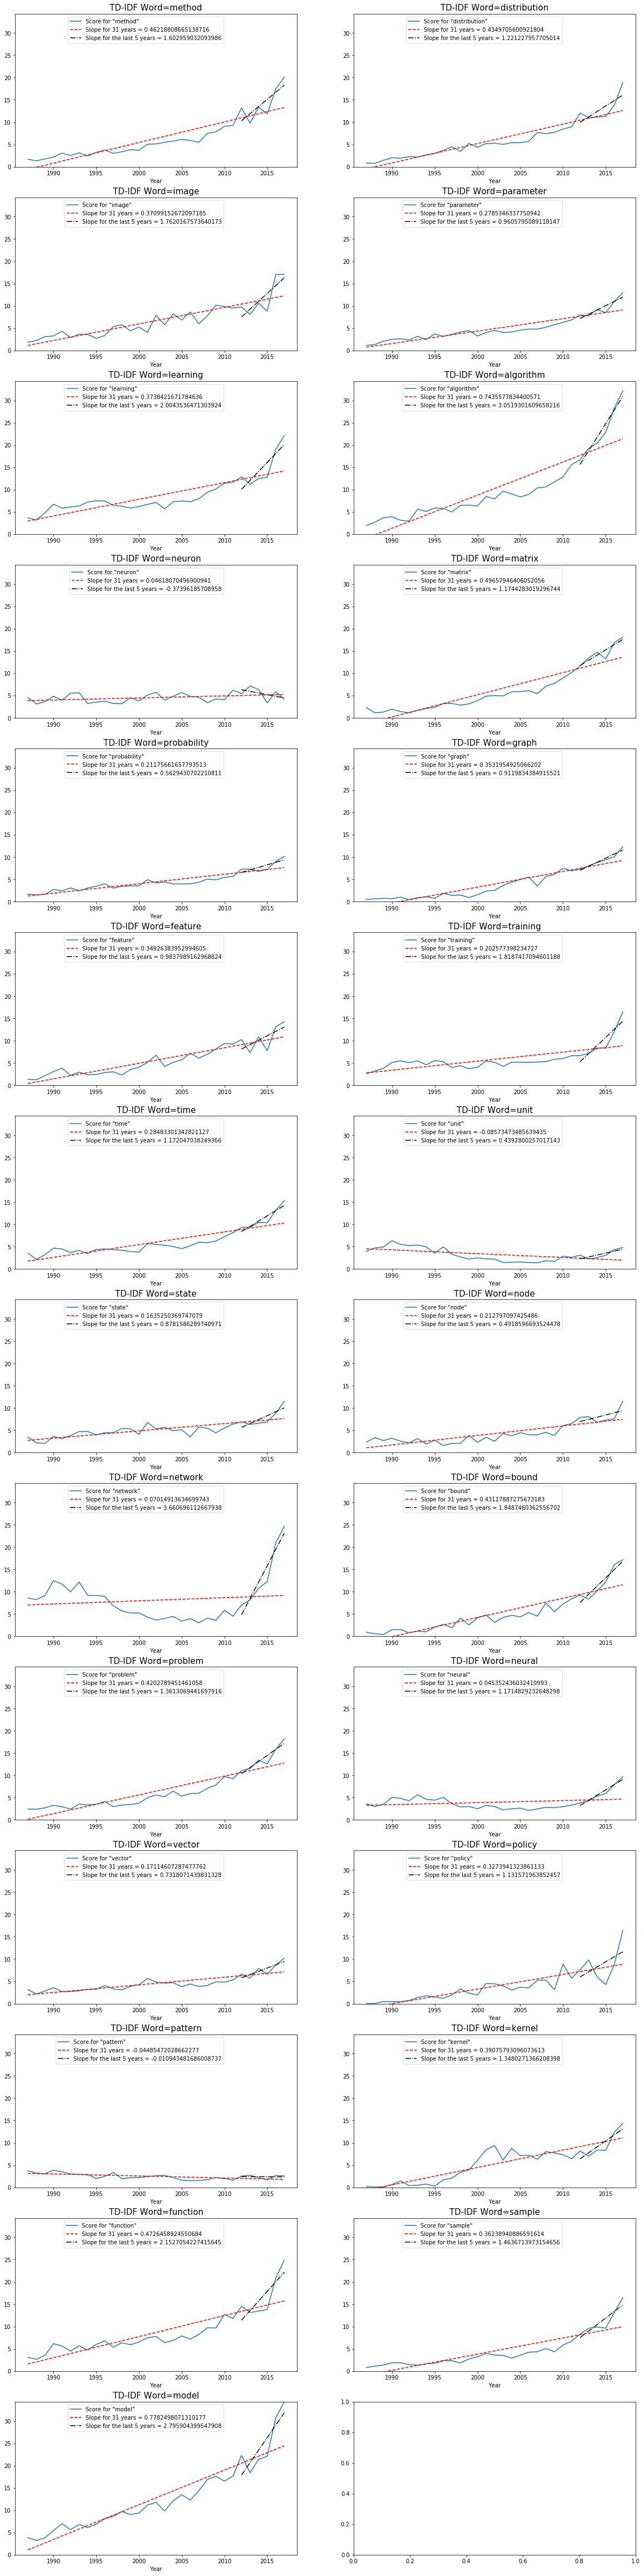

In [159]:
term_slope_df = plot_term_df_individually(tf_idf_word_df, term_name = "TD-IDF Word")

<span style="color:blue">
    In the below 3 tables we can see the some facts, always after preprocessing and normalizing:<br>
    -The most frequent words are `model`, `algorithm`, `function`, `learning` and `network`.<br>
    -The words with better trend in 31 years are `model`, `algorithm`, `matrix`, `function` and `method`.<br>
    -The words that show better trend in the last 5 years are `network`, `algorithm`, `model`, `function` and `learning`.
</span>

In [183]:
term_slope_df.sort_values(by='Mean score', ascending = False).iloc[:,[0,1]]

Term  Mean score
26         model   12.782182
5      algorithm   10.252495
24      function    8.681246
4       learning    8.573152
16       network    8.106989
2          image    6.702543
18       problem    6.475187
0         method    6.368034
7         matrix    6.177946
1   distribution    6.087651
12          time    6.026884
11      training    5.815234
10       feature    5.628944
23        kernel    5.251243
14         state    5.208865
17         bound    5.101120
3      parameter    4.908355
20        vector    4.579143
6         neuron    4.564014
25        sample    4.531589
8    probability    4.434101
15          node    4.284460
19        neural    3.993024
21        policy    3.936712
9          graph    3.936592
13          unit    3.254593
22       pattern    2.473723

In [162]:
term_slope_df.sort_values(by='Total slope', ascending = False).iloc[:,[0,2]]

Term  Total slope
26         model     0.778250
5      algorithm     0.743558
7         matrix     0.496579
24      function     0.472646
0         method     0.462188
1   distribution     0.434971
17         bound     0.431179
18       problem     0.420279
23        kernel     0.390758
4       learning     0.373842
2          image     0.370992
25        sample     0.362389
9          graph     0.353195
10       feature     0.349264
21        policy     0.327394
12          time     0.284833
3      parameter     0.278535
15          node     0.212797
8    probability     0.211757
11      training     0.202577
20        vector     0.171146
14         state     0.163525
16       network     0.070149
6         neuron     0.046181
19        neural     0.045352
22       pattern    -0.044855
13          unit    -0.085735

In [165]:
term_slope_df.sort_values(by='Last years slope', ascending = False).iloc[:,[0,3]]

Term  Last years slope
16       network          3.660696
5      algorithm          3.051930
26         model          2.795904
24      function          2.152705
4       learning          2.004354
17         bound          1.848746
11      training          1.818742
2          image          1.762017
0         method          1.602959
25        sample          1.463671
18       problem          1.361307
23        kernel          1.348027
1   distribution          1.221228
7         matrix          1.174428
12          time          1.172047
19        neural          1.171483
21        policy          1.131572
10       feature          0.983799
3      parameter          0.960580
9          graph          0.911983
14         state          0.878159
20        vector          0.731807
8    probability          0.562943
15          node          0.491860
13          unit          0.439280
22       pattern         -0.010943
6         neuron         -0.373962

## TF-IDF with 2-gram analysis

<span style="color:blue">
    By far, this analysis has been the one to take longer in terms of execution time, and it is because there is a method that appends a DataFrame to another DataFrame and this operation is really time consuming. <br>
    In the 2-gram analysis we are selecting the 25 most frequent terms during the 31 years, plus the most frequent term each year (in the case it is not among the TOP 25 most frequent)<br>
    We are normalizing following the criteria explain at the beginning of the section.
</span>

In [182]:
t0 = time()

tf_idf_word_df = get_tf_idf_per_year(years, paper_text_lc, stop = stop_words, num_freq_words=25, 
                                     ngram = 2, debug = False)

print("done in %0.3fs." % (time() - t0))

done in 13585.937s.


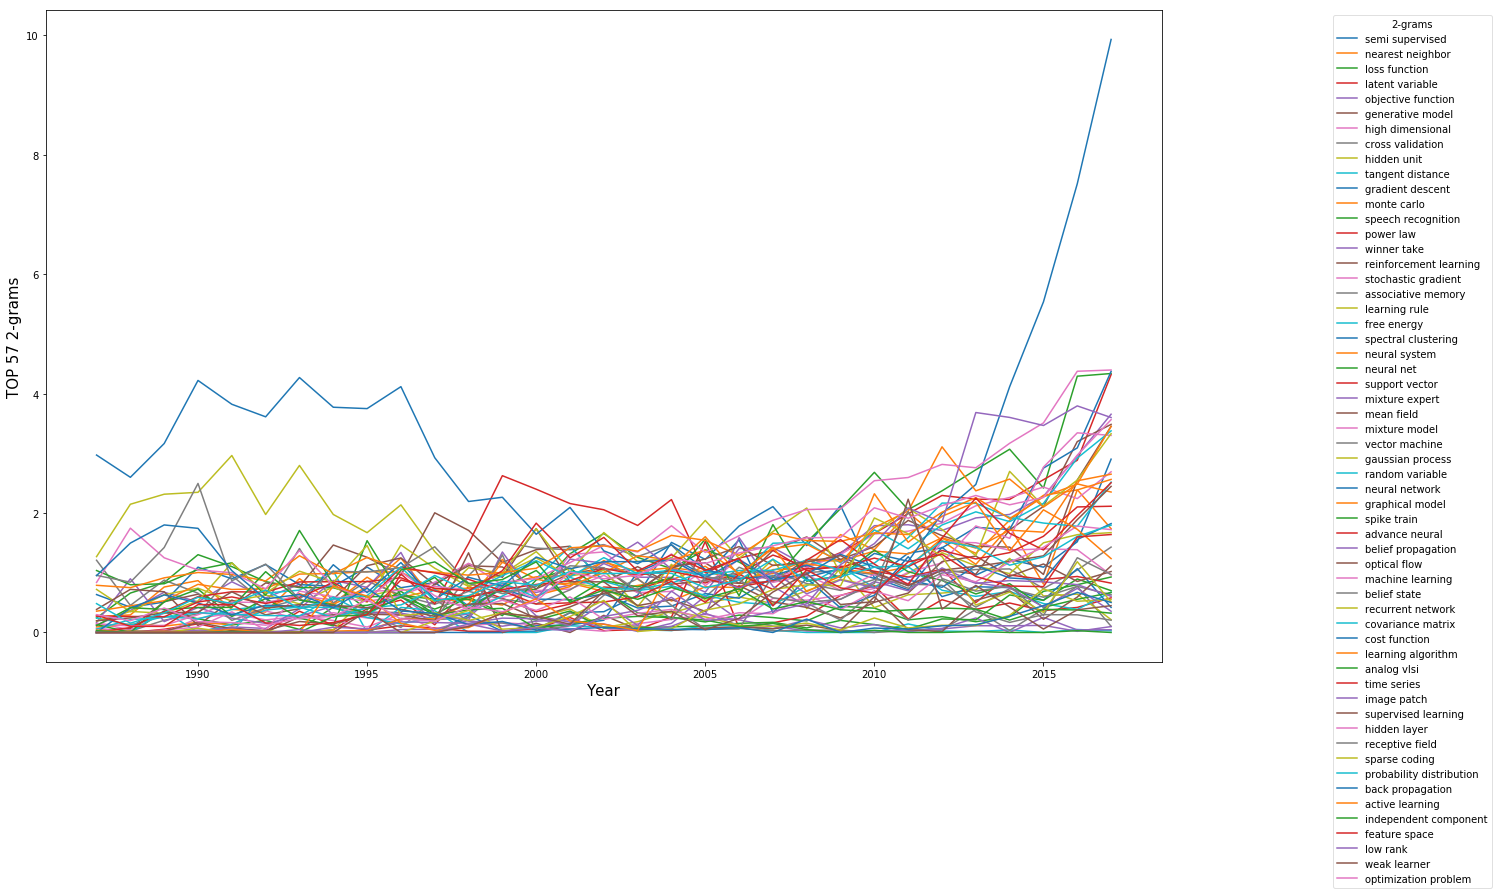

In [184]:
plot_term_df_all_together(tf_idf_word_df, term_name = "2-grams")

# 8 TRENDS ARE MADE OUT BELOW

<span style="color:blue">
1)	Neural Network<br>
2)	Gradient descent<br>
3)	Generative models<br>
4)	Stochastic gradient<br>
5)	Machine learning<br>
6)	Latent variables<br>
7)	Reinforcement learning<br>
8)	Speech recognition
</span>

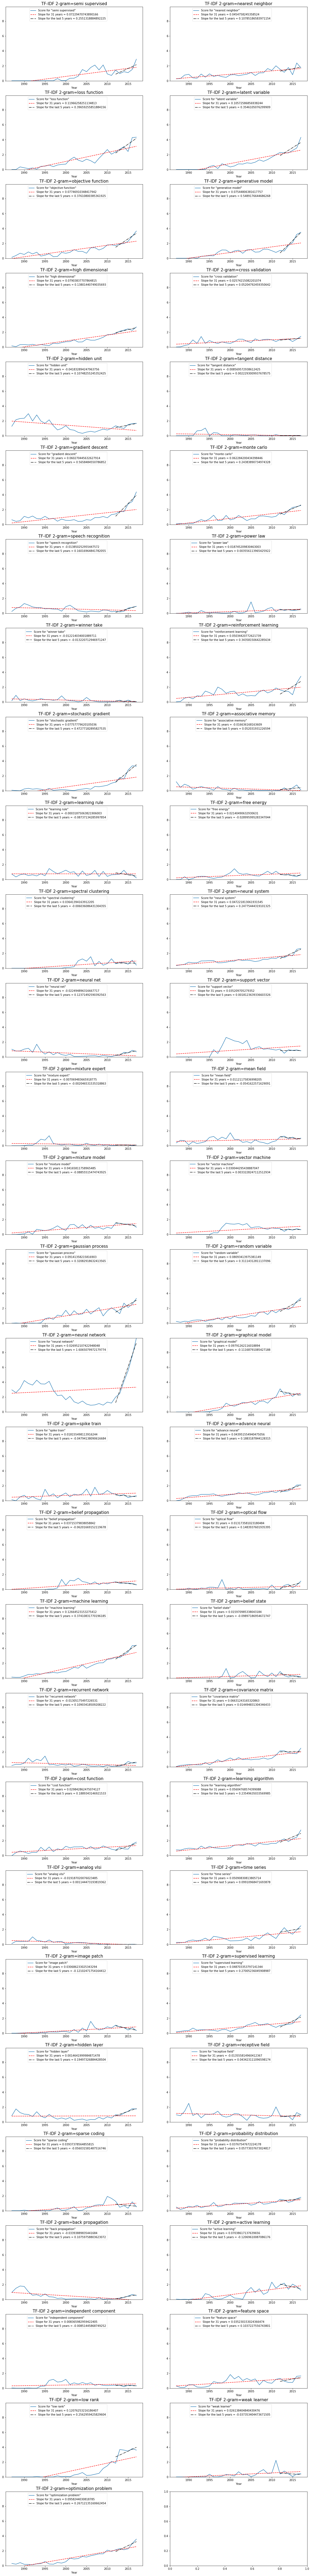

In [188]:
term_slope_df = plot_term_df_individually(tf_idf_word_df, term_name = "TF-IDF 2-gram")

<span style="color:blue">
    In the below 3 tables we can see the following facts:<br>
    -The most frequent words are `neural network`, `machine learning`, `learning algorithm`, `hidden unit` and `loss function`.<br>
    -The words with better trend in 31 years are `machine learning`, `low rank`, `loss function`, `latent variable` and `graphical model`.<br>
    -The words that show better trend in the last 5 years are `neural network`, `gradient descent`, `generative model`, `stochastic gradient` and `loss function`.
</span>

In [189]:
term_slope_df.sort_values(by='Mean score', ascending = False).iloc[:,[0,1]]

Term  Mean score
30            neural network    2.917753
36          machine learning    1.559763
41        learning algorithm    1.453028
8                hidden unit    1.341662
2              loss function    1.325635
15    reinforcement learning    1.229499
28          gaussian process    1.168157
4         objective function    1.127717
56      optimization problem    1.119995
21             neural system    1.116601
10          gradient descent    1.104045
31           graphical model    1.050201
29           random variable    1.045579
39         covariance matrix    1.021494
3            latent variable    1.012251
6           high dimensional    0.967393
1           nearest neighbor    0.963907
11               monte carlo    0.950537
33            advance neural    0.948757
47           receptive field    0.947674
43               time series    0.942071
23            support vector    0.938858
5           generative model    0.920586
40             cost function    0.909347
49  probability distribution    0.898003
54                  low rank    0.887478
53             feature space    0.836121
26             mixture model    0.826830
45       supervised learning    0.815124
46              hidden layer    0.799577
51           active learning    0.777095
7           cross validation    0.767131
18             learning rule    0.758324
25                mean field    0.750854
32               spike train    0.744055
0            semi supervised    0.728705
16       stochastic gradient    0.663190
27            vector machine    0.645007
34        belief propagation    0.582519
12        speech recognition    0.562983
19               free energy    0.543804
22                neural net    0.490946
52     independent component    0.440929
50          back propagation    0.428736
20       spectral clustering    0.416030
48             sparse coding    0.413882
38         recurrent network    0.395886
44               image patch    0.388791
55              weak learner    0.328123
17        associative memory    0.280311
37              belief state    0.276038
13                 power law    0.261136
35              optical flow    0.241619
42               analog vlsi    0.236510
14               winner take    0.233305
24            mixture expert    0.200952
9           tangent distance    0.129818

In [190]:
term_slope_df.sort_values(by='Total slope', ascending = False).iloc[:,[0,2]]

Term  Total slope
36          machine learning     0.126645
54                  low rank     0.120763
2              loss function     0.119663
3            latent variable     0.105726
31           graphical model     0.097913
56      optimization problem     0.095824
28          gaussian process     0.091414
29           random variable     0.080934
6           high dimensional     0.079038
16       stochastic gradient     0.077578
4         objective function     0.077469
5           generative model     0.075448
0            semi supervised     0.072295
51           active learning     0.070386
39         covariance matrix     0.066312
11               monte carlo     0.062284
10          gradient descent     0.060270
41        learning algorithm     0.056048
43               time series     0.050908
15    reinforcement learning     0.050344
45       supervised learning     0.048703
21             neural system     0.047222
1           nearest neighbor     0.045476
33            advance neural     0.043952
26             mixture model     0.041658
48             sparse coding     0.039374
49  probability distribution     0.037675
34        belief propagation     0.037154
20       spectral clustering     0.036414
53             feature space     0.035230
23            support vector     0.035210
44               image patch     0.030686
27            vector machine     0.030044
40             cost function     0.029843
30            neural network     0.026952
55              weak learner     0.026138
7           cross validation     0.025742
19               free energy     0.021405
13                 power law     0.018745
32               spike train     0.018155
37              belief state     0.015971
35              optical flow     0.013174
25                mean field     0.011212
52     independent component     0.008366
46              hidden layer     0.001464
18             learning rule    -0.000319
24            mixture expert    -0.007069
9           tangent distance    -0.008570
14               winner take    -0.012214
38         recurrent network    -0.013052
47           receptive field    -0.013556
12        speech recognition    -0.013850
17        associative memory    -0.016636
42               analog vlsi    -0.019187
22                neural net    -0.022495
50          back propagation    -0.033939
8                hidden unit    -0.041833

In [191]:
term_slope_df.sort_values(by='Last years slope', ascending = False).iloc[:,[0,3]]

Term  Last years slope
30            neural network          1.606508
10          gradient descent          0.565848
5           generative model          0.548918
16       stochastic gradient          0.472772
2              loss function          0.396593
4         objective function          0.376108
36          machine learning          0.374108
3            latent variable          0.354611
15    reinforcement learning          0.343582
28          gaussian process          0.320829
29           random variable          0.311143
45       supervised learning          0.270052
56      optimization problem          0.267121
54                  low rank          0.256296
0            semi supervised          0.255132
21             neural system          0.247754
11               monte carlo          0.243839
41        learning algorithm          0.235496
46              hidden layer          0.194973
40             cost function          0.188934
33            advance neural          0.188319
12        speech recognition          0.160170
35              optical flow          0.148394
6           high dimensional          0.138014
22                neural net          0.123715
38         recurrent network          0.109034
1           nearest neighbor          0.107852
50          back propagation          0.107598
8                hidden unit          0.107483
53             feature space          0.103723
43               time series          0.099110
49  probability distribution          0.057730
7           cross validation          0.052048
17        associative memory          0.052032
47           receptive field          0.043423
39         covariance matrix          0.014495
13                 power law          0.003556
27            vector machine          0.003323
9           tangent distance          0.002229
23            support vector          0.001812
42               analog vlsi          0.001144
24            mixture expert         -0.002047
20       spectral clustering         -0.006036
52     independent component         -0.008514
14               winner take         -0.013221
19               free energy         -0.028996
55              weak learner         -0.037353
32               spike train         -0.047941
25                mean field         -0.054162
48             sparse coding         -0.056032
34        belief propagation         -0.062017
18             learning rule         -0.087371
26             mixture model         -0.088555
37              belief state         -0.098972
31           graphical model         -0.111688
51           active learning         -0.120696
44               image patch         -0.121025

# Compound word option - LDA

<span style="color:blue">
    The third approach is Latent Dirichlet Allocation (LDA). In this case, we are using the library `gensim` to fit the model, as well as to try to extract the appropriate number of concepts and their corresponding words in the documents.<br><br>
    Initially, we are executing a validation to find the correct number of concepts. Through a different validation, we had adjusted the parameters `alfa` and `eta` to `50.0/1.0*np.ones((num_topics))` and `0.1`. Considering those values for alfa and eta, we are going to fit a model using from 10 to 40 concepts, in incrementals of 5. For each model, given a number of concepts, we are calculating the `Coherence` score (also provided by gensim`, and plotting the results to see by the eye the most appropriate.<br><br>
    We are not using the entire corpora of documents for this number of concepts tuning, as it is very time consuming. For the test, we are using 1000 documents, selected randomly.<br><br>
    Once we know the right parameters, we fit a model with the entire corpora.
</span>

### Test coherence

In [192]:
def test_lda_parameters(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    # Iterate through the range of concepts to validate
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus, num_topics=num_topics, 
                               id2word = dictionary, passes=100,alpha=50.0/1.0*np.ones((num_topics)), eta=0.1,
                                         random_state=9999)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [194]:
num_docs = 500

start = 10
limit = 40
step = 5

# We select a list of random documents to run the test
random_documents = random.sample(paper_text_lc, num_docs)

# Corpora
processed_corpora = preprocess_corpora(random_documents)
dictionary = corpora.Dictionary(processed_corpora)
corpus = [dictionary.doc2bow(doc) for doc in processed_corpora]

t0 = time()


model_list, coherence_values = test_lda_parameters(dictionary=dictionary, corpus=corpus, 
                                                        texts=processed_corpora, start=start, limit=limit, step=step)

print("done in %0.3fs." % (time() - t0))

done in 1677.606s.


<span style="color:blue">
    Considering the below plot, the best range to select the number of topics is between 15 and 20. We are going to select 20.
</span>

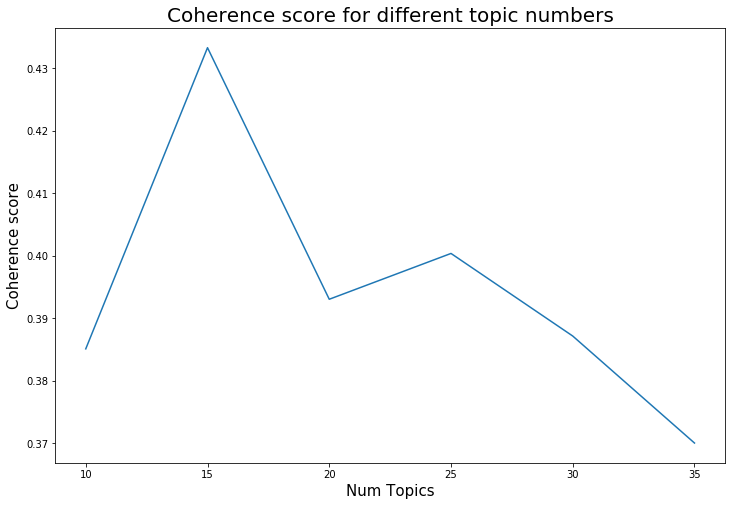

In [195]:
plt.figure(figsize=(12, 8))
plt.title('Coherence score for different topic numbers', fontsize=20)
ax = plt.gca()

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=15)
plt.ylabel("Coherence score", fontsize=15)

plt.show()

## LDA model

<span style="color:blue">
    The essential part of this approach consist of computing the topic distribution of the documents and words that make up the corpora for each year.<br>
    We put together all the documents for a given year and find the topic numbers that have the highest percentage contribution in set of documents.
</span>

In [15]:
def get_lda_topic_distr_per_year(years, corpora, lda_model, debug = False):
    # Create a list with the unique years
    year_list = list(sorted(set(years)))
    
    topics_distr_per_year = []
    
    # Iterate for each year
    for year in year_list:
        # List of the indexes that contains the row numbers of a given year
        idx = [i-1 for i, x in enumerate(years) if x == year]
        
        # Sub-vector with the documents for a given year
        documents_in_a_year = [corpora[index] for index in idx]
        flat_list = [item for sublist in documents_in_a_year for item in sublist]
        
        if debug:
            print("Year = " + str(year))
            print("Documents in year = " + str(len(documents_in_a_year)))
        
        year_topic_distribution = lda_model[flat_list]
        distr = [d for topic, d in year_topic_distribution]
        topics_distr_per_year.append(distr)
        
    
    topic_info = lda_model.show_topics(num_topics = len(distr), num_words = 5, formatted=False)
    topics_words = ['_'.join([wd[0] for wd in tp[1]]) for tp in topic_info]
    
    topic_df = pd.DataFrame(topics_distr_per_year, columns = topics_words)
    topic_df.insert(loc=0, column='Year', value=year_list)
    
    return topic_df

<span style="color:blue">
    We fit the model with the entire corpora of documents and setting the number of topics to 15. Then, we obtain the topic distribution per year, considering all the documents that make up that year.
</span>

In [35]:
num_topics = 15

#num_docs = 500
#random_documents = paper_text_lc[0:num_docs]
#processed_corpora = preprocess_corpora(random_documents)

# Corpora
processed_corpora = preprocess_corpora(paper_text_lc)

dictionary = corpora.Dictionary(processed_corpora)
corpus = [dictionary.doc2bow(doc) for doc in processed_corpora]

t0 = time()

lda = models.ldamodel.LdaModel(corpus, num_topics=num_topics, 
                               id2word = dictionary, passes=100,alpha=20.0/1.0*np.ones((num_topics)),
                              eta=0.1, random_state=9999)

print("done in %0.3fs." % (time() - t0))

done in 1360.200s.


In [36]:
topic_df = get_lda_topic_distr_per_year(years, corpus, lda, debug = False)
#topic_df = get_lda_topic_distr_per_year(years[0:num_docs], corpus, lda, debug = False)

<span style="color:blue">
    Below we can see a plot with the score that identifies the contribution of each topic to the sub-corpora of every year.
</span>

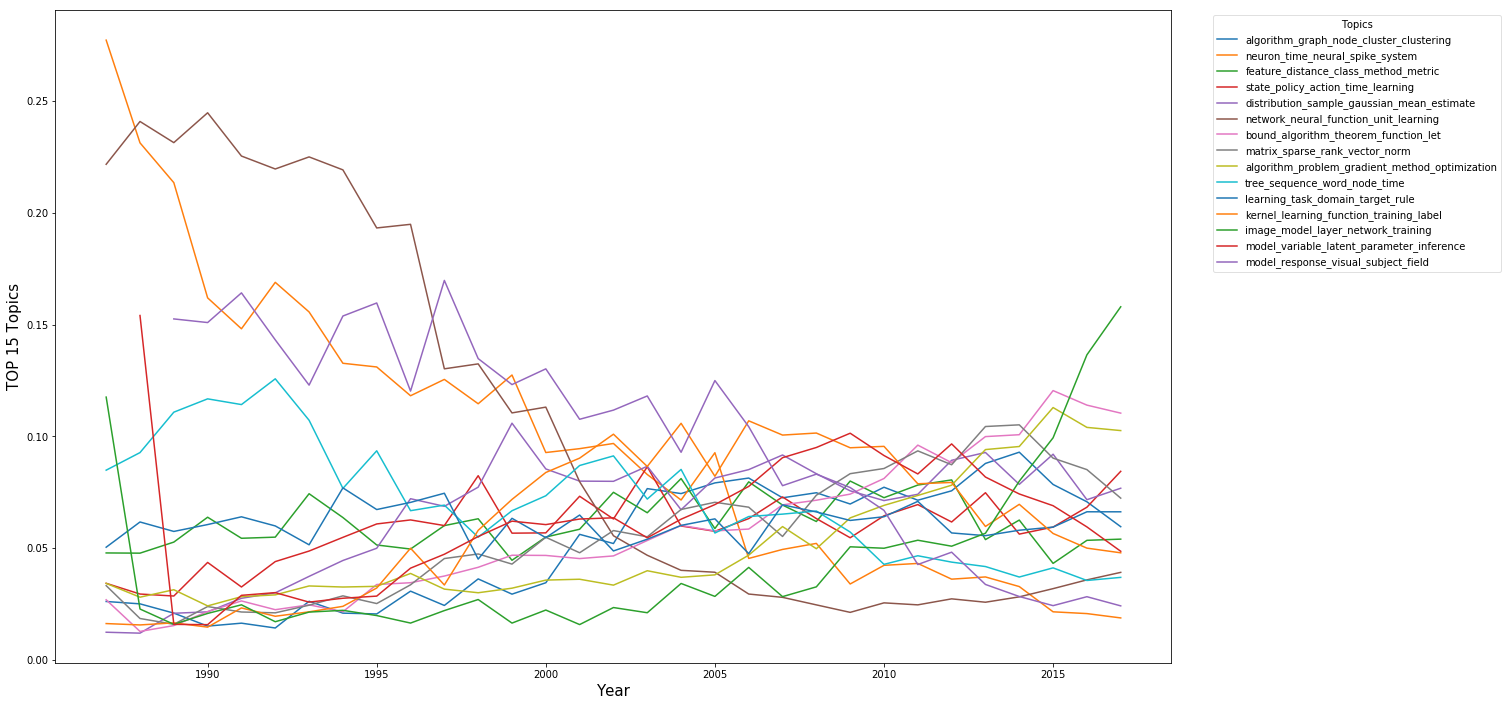

In [37]:
plot_term_df_all_together(topic_df, "Topics")

# 2 TRENDS ARE MADE OUT BELOW

<span style="color:blue">
1)	Object detection using deep learning (coming from the concept made up of image_layer_network_object_training).<br>
2)	Markov decision process (coming from the concept state_time_policy_action_reward)
</span>

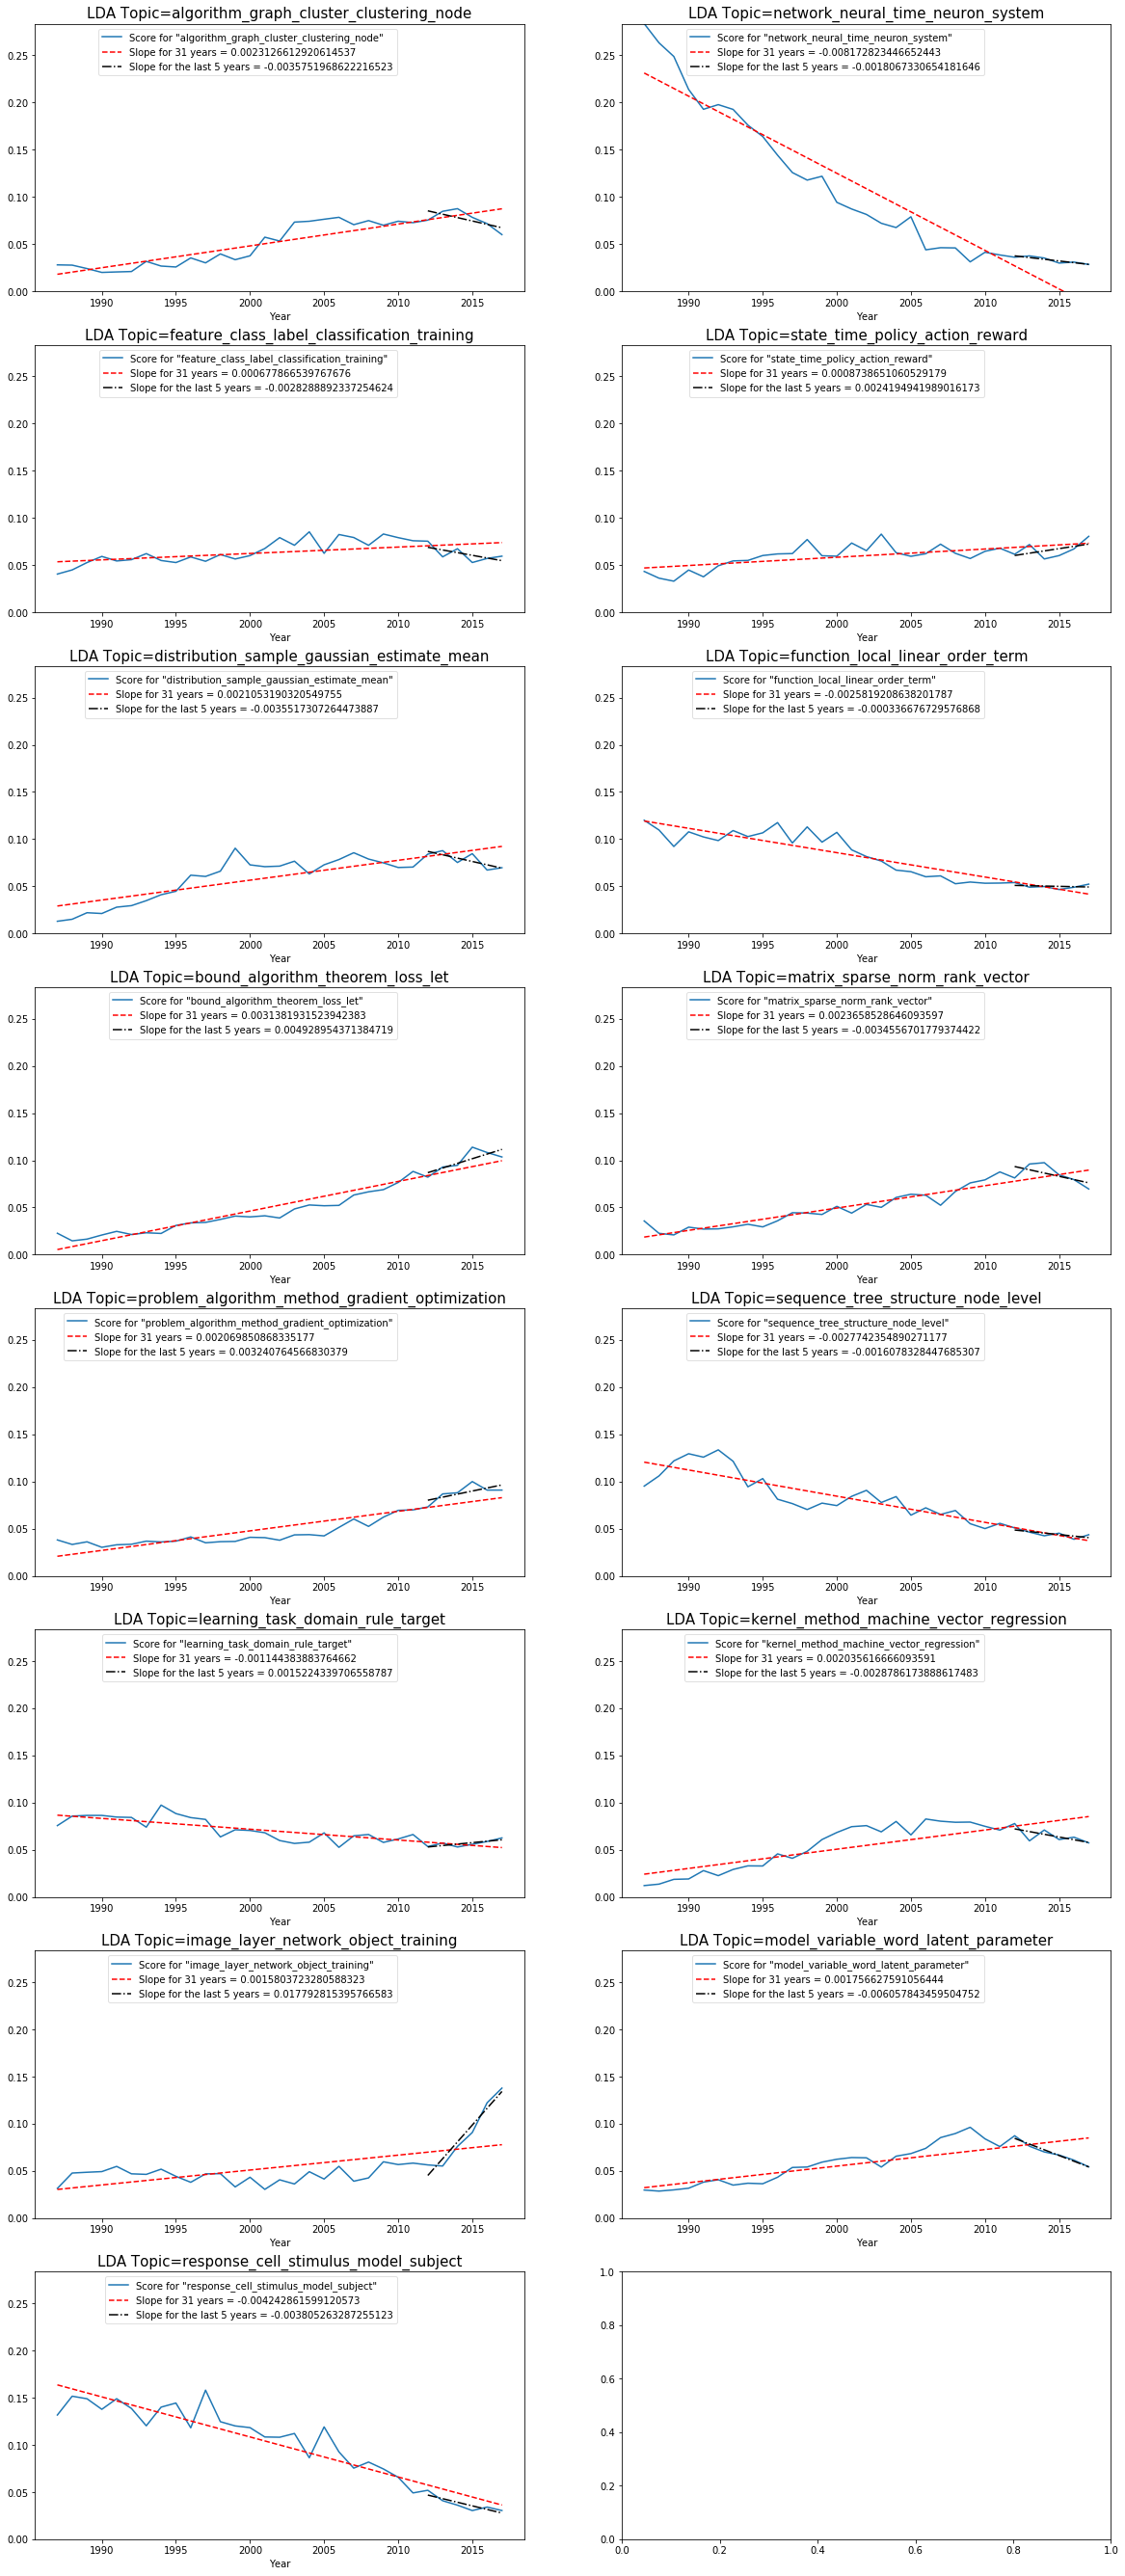

In [18]:
term_slope_df = plot_term_df_individually(topic_df, "LDA Topic")

In [19]:
term_slope_df.sort_values(by='Mean score', ascending = False).iloc[:,[0,1]]

Term  Mean score
1                network_neural_time_neuron_system    0.108641
14            response_cell_stimulus_model_subject    0.099830
5                 function_local_linear_order_term    0.080483
9               sequence_tree_structure_node_level    0.078796
10                learning_task_domain_rule_target    0.069439
2      feature_class_label_classification_training    0.063781
4       distribution_sample_gaussian_estimate_mean    0.060723
3                  state_time_policy_action_reward    0.060153
13            model_variable_word_latent_parameter    0.058540
11         kernel_method_machine_vector_regression    0.054608
7                   matrix_sparse_norm_rank_vector    0.054108
12             image_layer_network_object_training    0.054016
0          algorithm_graph_cluster_clustering_node    0.052684
6                 bound_algorithm_theorem_loss_let    0.052473
8   problem_algorithm_method_gradient_optimization    0.051727

In [20]:
term_slope_df.sort_values(by='Total slope', ascending = False).iloc[:,[0,2]]

Term  Total slope
6                 bound_algorithm_theorem_loss_let     0.003138
7                   matrix_sparse_norm_rank_vector     0.002366
0          algorithm_graph_cluster_clustering_node     0.002313
4       distribution_sample_gaussian_estimate_mean     0.002105
8   problem_algorithm_method_gradient_optimization     0.002070
11         kernel_method_machine_vector_regression     0.002036
13            model_variable_word_latent_parameter     0.001757
12             image_layer_network_object_training     0.001580
3                  state_time_policy_action_reward     0.000874
2      feature_class_label_classification_training     0.000678
10                learning_task_domain_rule_target    -0.001144
5                 function_local_linear_order_term    -0.002582
9               sequence_tree_structure_node_level    -0.002774
14            response_cell_stimulus_model_subject    -0.004243
1                network_neural_time_neuron_system    -0.008173

In [21]:
term_slope_df.sort_values(by='Last years slope', ascending = False).iloc[:,[0,3]]

Term  Last years slope
12             image_layer_network_object_training          0.017793
6                 bound_algorithm_theorem_loss_let          0.004929
8   problem_algorithm_method_gradient_optimization          0.003241
3                  state_time_policy_action_reward          0.002419
10                learning_task_domain_rule_target          0.001522
5                 function_local_linear_order_term         -0.000337
9               sequence_tree_structure_node_level         -0.001608
1                network_neural_time_neuron_system         -0.001807
2      feature_class_label_classification_training         -0.002829
11         kernel_method_machine_vector_regression         -0.002879
7                   matrix_sparse_norm_rank_vector         -0.003456
4       distribution_sample_gaussian_estimate_mean         -0.003552
0          algorithm_graph_cluster_clustering_node         -0.003575
14            response_cell_stimulus_model_subject         -0.003805
13            model_variable_word_latent_parameter         -0.006058

In [201]:
print("done in %0.3fs." % (time() - tx))

done in 92606.349s.


# Word2vec

<span style="color:blue">
    In this section, we use `Word2Vec` to process all texts in the `paper_text_lc` file. Essentially, `Word2Vec` uses shallow and two-layer neural networks to produce words embedding and to map each word vector to a real number. With these embedded word vectors as the parameters for the hidden layers of neural networks, we can analyze the relationships between the words in the text file. We will conduct the `Wod2Vec` analysis on the `paper_text_lc` file and analyze the top 10 similar words for each word in the `top_words_list`. The `top_words_list` contains 5 very frequent words in the `paper_text_lc` file, including `model`, `algorithm`, `function`, `learning`, and `network`. Note that the concept, `similar words`, here means the words that are semantically close to a given word.
</span>

In [18]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

stop_words = create_stop_words()

# Use Word2Vec to find the top smilar words of the most frequent words in the paper texts
processed_corpora = preprocess_corpora(paper_text_lc)
model_Word = Word2Vec(processed_corpora, size=200, window=4, min_count=100, workers=4)
Word2Vec_word_vectors = model_Word.wv

def Word2Vec_most_similar_word (word):
    result = Word2Vec_word_vectors.most_similar(positive=[word])
    print("The top 10 words most similar to " + str(word) + ":")
    print(result)
    print("\n")    

top_words_list = ["model", "algorithm", "function", "learning", "network"]
for word_number in range(0, len(top_words_list)):
    Word2Vec_most_similar_word (top_words_list[word_number])

The top 10 words most similar to model:
[('modeling', 0.5325260162353516), ('hmms', 0.5147757530212402), ('lds', 0.48206043243408203), ('fhmm', 0.4766579270362854), ('modelling', 0.4721730947494507), ('glm', 0.44931459426879883), ('hmm', 0.448511004447937), ('approach', 0.4385265111923218), ('slds', 0.4310624599456787), ('vaes', 0.4273970127105713)]


The top 10 words most similar to algorithm:
[('procedure', 0.712940514087677), ('method', 0.708260178565979), ('subroutine', 0.6647680997848511), ('scheme', 0.6273758411407471), ('alg', 0.6034165620803833), ('technique', 0.5883862972259521), ('variant', 0.5845822095870972), ('approach', 0.561335563659668), ('heuristic', 0.5427918434143066), ('strategy', 0.5059860944747925)]


The top 10 words most similar to function:
[('functionals', 0.5050827264785767), ('nondecreasing', 0.4986557960510254), ('surrogate', 0.49755239486694336), ('pointwise', 0.46838489174842834), ('monotone', 0.4595721364021301), ('minimized', 0.4559788107872009), ('piec

D:\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Doc2vec

<span style="color:blue">
    In this section, we use `Doc2Vec` to process all texts in the `paper_text_lc` file. Different from `Word2Vec`, which analyzes similarity between words vectors, `Doc2Vec` tags the text documents (with `TaggedDocument` in the following code) and conducts analysis on tag vectors. In other words, `Doc2Vec` is more powerful that `Word2Vec` because the former vectorizes both words and documents. Here, in the tagged documents, we use `Doc2Vec` to find the top ten most similar words for each word in the same `top_words_list` as last section. The `top_words_list` contains 5 very frequent words in the `paper_text_lc` file, including `model`, `algorithm`, `function`, `learning`. The produced top ten silmilar words for each word using the `Doc2Vec` are similar to the results generated using `Doc2Vec`.
</span>

In [20]:
# Use Doc2Vec to find the most smilar words of some 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, TaggedLineDocument
processed_corpora = preprocess_corpora(paper_text_lc)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(processed_corpora)]
model_Doc = Doc2Vec(documents, vector_size=100, window=4, min_count=100, workers=4)
Doc2Vec_word_vectors = model_Doc.wv

def Doc2Vec_most_similar_word (word):
    result = Doc2Vec_word_vectors.most_similar(positive=[word])
    print("The top 10 words most similar to " + str(word) + ":")
    print(result)
    print("\n")
    top_words_list = ["model", "algorithm", "function", "learning", "network"] # Apriori Support
for word_number in range(0, len(top_words_list)):
    Doc2Vec_most_similar_word (top_words_list[word_number])

The top 10 words most similar to model:
[('classifier', 0.49319586157798767), ('modeling', 0.48464205861091614), ('hmms', 0.4811328649520874), ('glm', 0.47211211919784546), ('rbms', 0.46607357263565063), ('slda', 0.4641013443470001), ('architecture', 0.4551188349723816), ('network', 0.4507232904434204), ('approach', 0.45026254653930664), ('crfs', 0.44971752166748047)]


The top 10 words most similar to algorithm:
[('method', 0.7576336860656738), ('procedure', 0.7571868896484375), ('scheme', 0.6801204681396484), ('technique', 0.6344639658927917), ('approach', 0.6125723719596863), ('subroutine', 0.6111419796943665), ('alg', 0.5589331388473511), ('algo', 0.548569917678833), ('variant', 0.5266997814178467), ('solver', 0.5182037353515625)]


The top 10 words most similar to function:
[('instantaneous', 0.49212855100631714), ('operator', 0.4913209080696106), ('functionals', 0.48793894052505493), ('surrogate', 0.47594618797302246), ('monotone', 0.4701024293899536), ('functional', 0.4606290459

D:\Anaconda\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Apriori Support

<span style="color:blue">
    In this part, we use `Apriori` to extract frequent itemsets from `title_lc` file. Due to the long computational time of the `paper_text_lc` file in this problem, we will instead use the `title_lc` file here. We will use `min_support=0.03` in the analysis. We first will determine the top 10 frequent words in all tiles for each individual year, and then will construct a list to collect all of the frequent words in all years.  For each word in this list, we will list its support value in different year. Then we will obtain a datdaframe of which each column contain the support values (in different years) of an invidual frequent word. We will remove the columns that have only less than 5 nonzero support values. Then we will plot the changes of the frequent words with time. Even the number of word samples in the `title_lc` file is less than that in the `paper_text_lc` file, we still can see that, for some frequent words, such as `network`, the trends of their support values are simialr to the trends of their frequencies. 
</span>

In [24]:
# For the titles in each invidual year, find the top ten itemsets (words or word combinations)
# having the highest support values.
# Note: "Support" means the ratio of the number of documents containing a particular word to the 
# total number of documents.
from mlxtend.preprocessing import TransactionEncoder
TE = TransactionEncoder()

year_list = list(sorted(set(years)))


# Build an index list for years
title_years_index = []
title_years_index_length = []
for year in year_list:
      # List of the indexes that contains the row numbers of a given year
        idx = [i for i, x in enumerate(years) if x == year]
        title_years_index.append(idx)
        title_years_index_length.append(len(idx))
#print(title_years_index)
#print(title_years_index_length)
#title_years_index

# We use fit method in TransactionEncoder to learns the unique labels in the dataset
# We use transform method in TransactionEncoder to transform the input dataset into a one-hot encoded boolean array
# Apply to title_tokens list
processed_title = preprocess_corpora(title_lc)
te_ary = TE.fit(processed_title).transform(processed_title)
title_TE = pd.DataFrame(te_ary, columns = TE.columns_)
title_TE.head(10)

from mlxtend.frequent_patterns import apriori

# For the titles in each invidual year, find the top ten itemsets (words or word combinations)
# having the highest support values.
# Note: "Support" means the ratio of the number of documents containing a particular word to the 
# total number of documents.
title_frequent_top10_items = []
title_frequent_top10_support = []
all_title_frequent_top10_items = []
all_title_frequent_top10_support = []
for year in year_list:
    #print("Year = " + str(year))
    #print("Documents in the year = " + str(title_years_index_length[year-1987]) + "\n")
    title_frequent_items = apriori(title_TE.loc[title_years_index[year-1987],:], min_support=0.03, use_colnames=True)
    title_frequent_items.sort_values('support', inplace=True, ascending=False)
    title_frequent_top10_items = title_frequent_items.iloc[:,1].head(10).tolist()
    title_frequent_top10_support = title_frequent_items.iloc[:,0].head(10).tolist()
    all_title_frequent_top10_items.append([list(x) for x in title_frequent_top10_items])
    all_title_frequent_top10_support.append([x for x in title_frequent_top10_support])
    # print(title_frequent_items, "\n")
    #print(title_frequent_top10, "\n")
    
#print(all_title_frequent_top10) 
#print(year_list)

items_support_list = []
for idx in range(31):
    A = list(zip(all_title_frequent_top10_items[idx], all_title_frequent_top10_support[idx]))
    items_support_list.append(A)
#print (items_support_list)
dictionary = dict(zip(year_list, items_support_list))
#dictionary 

merged_top_words_list = []
for year in year_list:
        for idx in range(8):
            merged_top_words_list.append([word for word in dictionary[year][idx][0] if not word in merged_top_words_list])

# Change the list containing sublists to one list with flattened_list
flattened_list  = [val for sublist in merged_top_words_list for val in sublist]

# Keep one only one copy for the repeated word in the flattened_list 
from collections import OrderedDict
top_word_list=list(OrderedDict.fromkeys(flattened_list))

# Initialize a dataframe for the top_word_list at different years
df_columnames = []
for word in top_word_list:
    df_columnames.append(word)  
df = pd.DataFrame(columns=df_columnames)

# Extract the support values of each words in the top_word_list in the dictionary and collect its support values in
# different years as a column in a dataframe.
word_support_values = []
for year in year_list:
    invidual_year_list = []
    words_in_invidual_year = []
    for idx in range(9):
        words_in_invidual_year.append(dictionary[year][idx][0][0])
    for word in top_word_list:
        if word in words_in_invidual_year:
            location = words_in_invidual_year.index(word)
            invidual_year_list.append( dictionary[year][location][1] )
        else:
            invidual_year_list.append(0)            
    word_support_values.append(invidual_year_list)

for year in year_list:
    df.loc[year-1987] = word_support_values[year-1987]

df.insert(loc=0, column='Year', value=year_list)

# Remove the columns in which the number of nonzero elements is less than 5:
delete_word_list = []
for column_name in df.columns:
    column_list = df[column_name].tolist()
    if np.count_nonzero(column_list) < 5:
        delete_word_list.append(column_name) 
df.drop(delete_word_list, axis=1, inplace=True)

<span style="color:blue">
    In the following plots of the `top_word_list` and the tables of `slopes`, we can see the following facts, in the `title_lc` file :<br>
    -The five words that have the highest support values are `network`, `neural`, `learning`, `model`, and `algorithm`. This result is very similar to what we got when analyzing the frequencies of words in the much larger `paper_text_lc` file, in which the five words with the highest frequencies are `model`, `algorithm`, `function`, `learning` and `nnetwork`.<br>
    -The words with better trend of the support value in 31 years are `learning`, `inference` and `process`, which is NOT the same as the words with the highest frequqncies that we obtained before. Because (1) the samples in the `title_lc` file is much less than that in the `paper_text_lc` file, and (2) `support value` is different from `frequency`. The high support values for `learning`, `inference` and `process` means that the percentage of the titles that contain these three words in all paper titles kept increasing in the past 31 years.  <br>
    -The words that show better trend in the last 5 years are `network` and `neural`. This indicates that the percentage of the titles that contain `network` and `neural` increases faster than other words. 
</span>

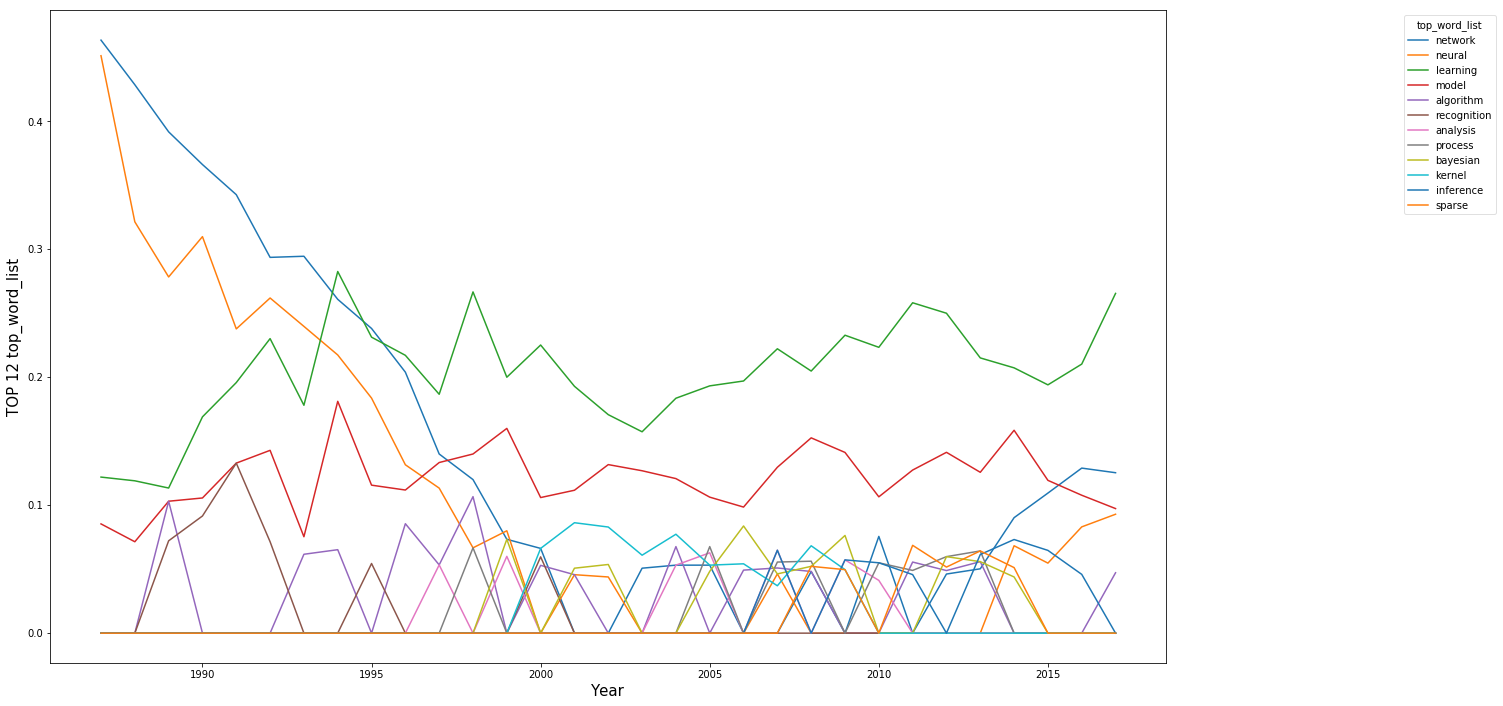

In [25]:
plot_term_df_all_together(df, term_name = "top_word_list")

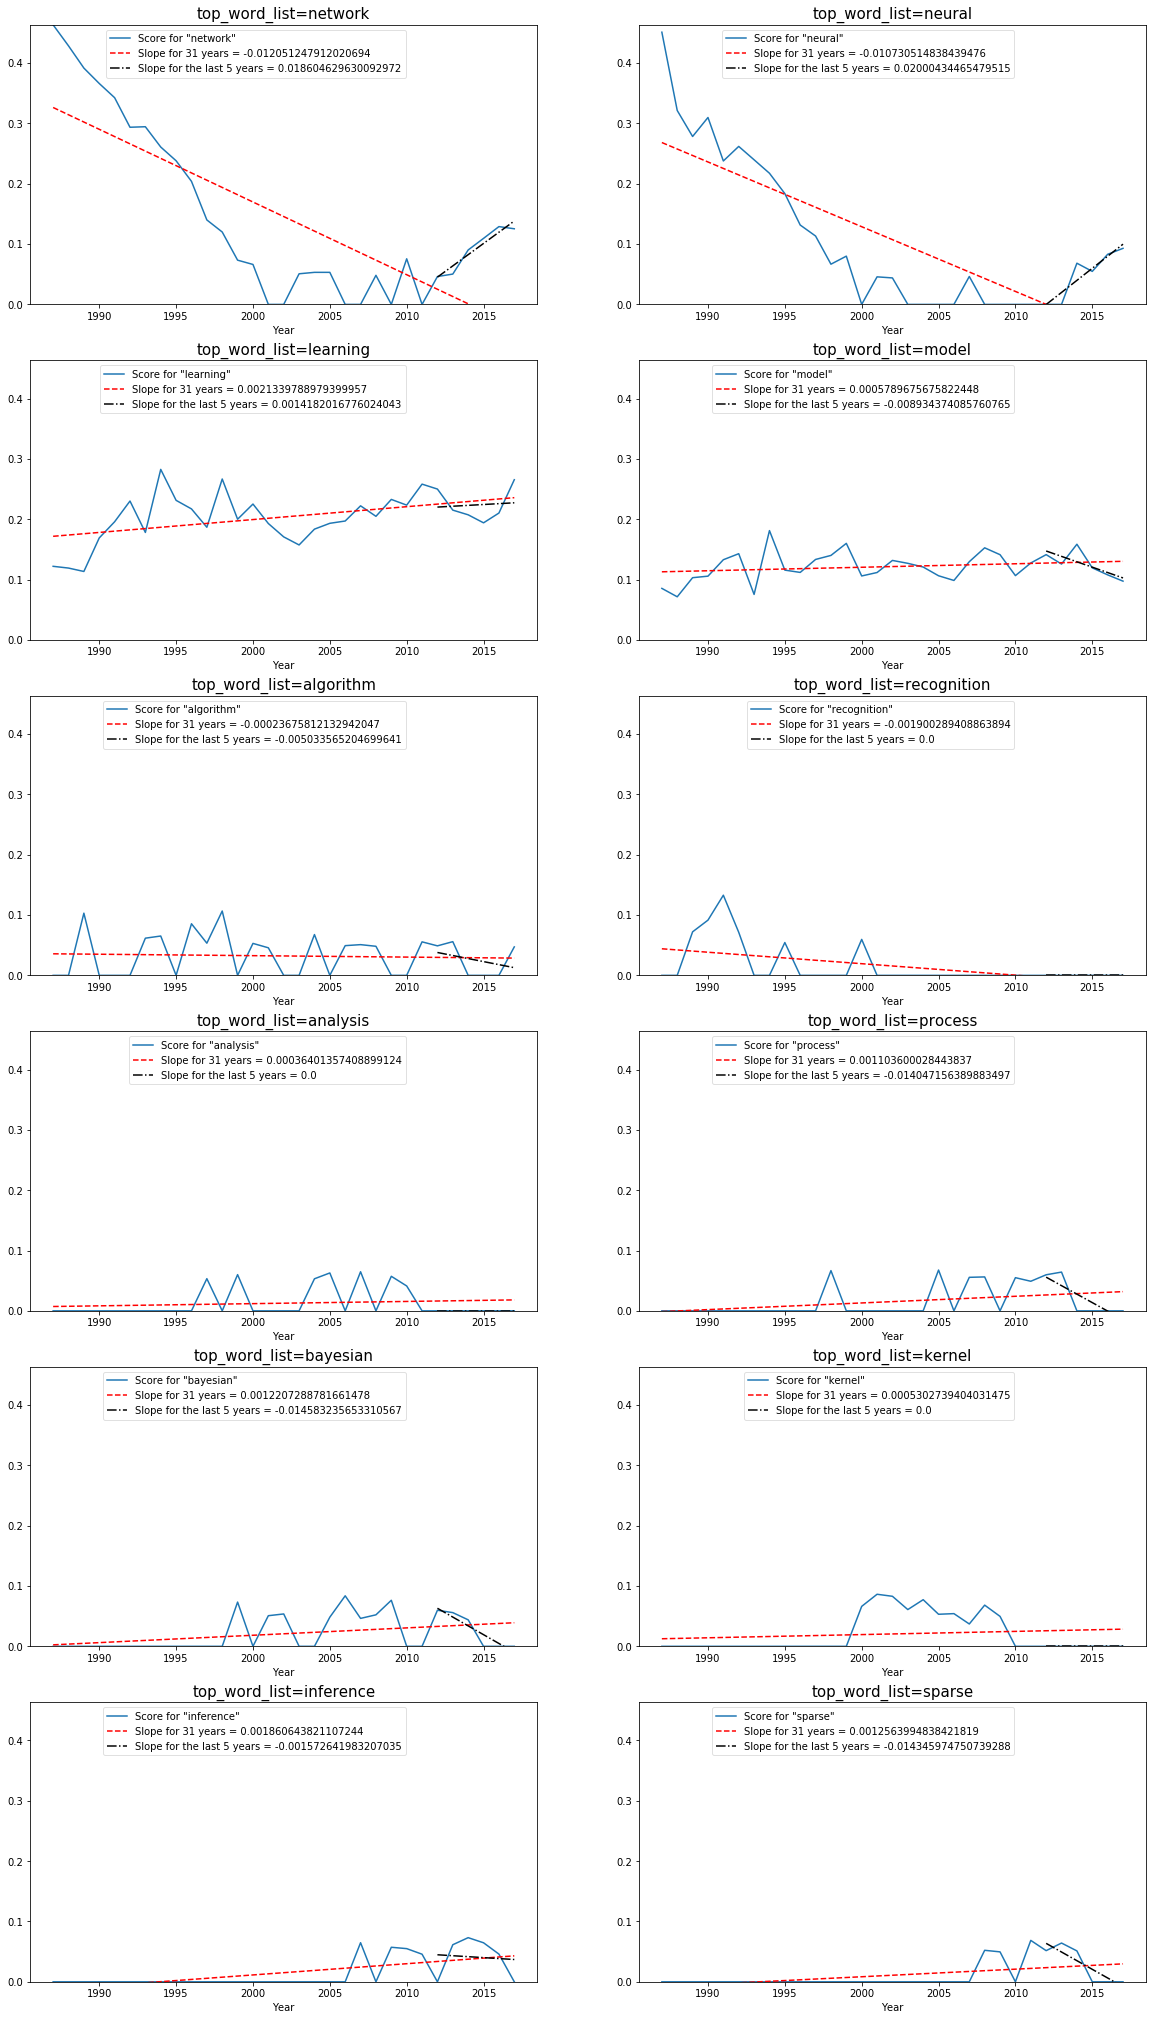

Term  Mean score  Total slope  Last years slope
0       network    0.145632    -0.012051          0.018605
1        neural    0.107347    -0.010731          0.020004
2      learning    0.203722     0.002134          0.001418
3         model    0.121545     0.000579         -0.008934
4     algorithm    0.032184    -0.000237         -0.005034
5   recognition    0.015549    -0.001900          0.000000
6      analysis    0.012664     0.000364          0.000000
7       process    0.015294     0.001104         -0.014047
8      bayesian    0.020781     0.001221         -0.014583
9        kernel    0.020513     0.000530          0.000000
10    inference    0.015098     0.001861         -0.001573
11       sparse    0.010889     0.001256         -0.014346

In [26]:
plot_term_df_individually(df, term_name = "top_word_list")